In [1]:
import time
import torch
import json
import random
import math
import warnings
import torchvision
import os
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torchvision.models as models

from pathlib import Path
from datetime import datetime
from tqdm import tqdm
from PIL import Image
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision.models import EfficientNet
from torchvision.datasets import ImageFolder

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Hyperparameters
learning_rate = 0.0005 # 0.096779
epochs = 200
epochs_pretrain = 3
epochs_optimal_lr = 3
patience = 6
momentum = 0.9
step_size = 30
gamma = 0.1
batch_size = 64
num_workers = 4

# list of lambda values to loop through for grid search
epsilon = 0.05
margin = 0.01
lambda_factor_list = [100,0,50,150,200]

# labels used including for plotting
class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_labels_new = torch.tensor([i for i in range(len(class_labels))])
num_classes = 16
class_names_new = [f"Class {label}" for label in range(num_classes)]


In [3]:
# set device to cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Check if CUDA is available
cuda_available = torch.cuda.is_available()

# Count the number of GPUs available
num_gpus = torch.cuda.device_count()

print("CUDA Available:", cuda_available)
print("Number of GPUs:", num_gpus)

torch.cuda.empty_cache()

CUDA Available: True
Number of GPUs: 1


In [4]:
# Assuming your JSON file is named 'your_file.json'
file_path = './WIDER/Annotations/wider_attribute_trainval.json'

with open(file_path, 'r') as file:
    # Load the JSON data from the file
    data = json.load(file)

class_idx = data['scene_id_map']

In [5]:
new_label_mapping = {
    0: "Team_Sports",
    1: "Celebration",
    2: "Parade",
    3: "Waiter_Or_Waitress",
    4: "Individual_Sports",
    5: "Surgeons",
    6: "Spa",
    7: "Law_Enforcement",
    8: "Business",
    9: "Dresses",
    10: "Water_Activities",
    11: "Picnic",
    12: "Rescue",
    13: "Cheering",
    14: "Performance_And_Entertainment",
    15: "Family"
}

# Ensure that all 16 new classes are covered
# If some classes are not explicitly mentioned in new_label_mapping, add them
for i in range(num_classes):
    if i not in new_label_mapping:
        new_label_mapping[i] = "Additional Category {}".format(i)

class_idx = new_label_mapping

In [6]:
class DataSet(Dataset):
    def __init__(self, ann_files, augs, img_size, dataset):

        # Create a mapping from old labels to new labels
        self.label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted(class_labels))}

        self.new_label_mapping = {
            0: 2,  # Parade
            1: 8,  # Business
            2: 7,  # Law Enforcement
            3: 14,  # Performance and Entertainment
            4: 1,  # Celebration
            5: 13,  # Cheering
            6: 8,  # Business
            7: 8,  # Business
            8: 1,  # Celebration
            9: 14,  # Performance and Entertainment
            10: 15, # Family
            11: 15, # Family
            12: 11, # Picnic
            13: 7, # Law Enforcement
            14: 6, # Spa
            15: 13, # Cheering
            16: 5, # Surgeons
            17: 3, # Waiter or Waitress
            18: 4, # Individual Sports
            19: 0, # Team Sports
            20: 0, # Team Sports
            21: 0, # Team Sports
            22: 4, # Individual Sports
            23: 10, # Water Activities
            24: 4, # Individual Sports
            25: 1, # Celebration
            26: 9, # Dresses
            27: 12, # Rescue
            28: 10,# Water Activities
            29: 0  # Team Sports
        }

        self.dataset = dataset
        self.ann_files = ann_files
        self.augment = self.augs_function(augs, img_size)
        # Initialize transformations directly
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
            ] 
        )
        if self.dataset == "wider":
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                ] 
            )        

        self.anns = []
        self.load_anns()
        print(self.augment)

    def augs_function(self, augs, img_size):            
        t = []
        if 'randomflip' in augs:
            t.append(transforms.RandomHorizontalFlip())
        if 'ColorJitter' in augs:
            t.append(transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0))
        if 'resizedcrop' in augs:
            t.append(transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)))
        if 'RandAugment' in augs:
            t.append(transforms.RandAugment())

        t.append(transforms.Resize((img_size, img_size)))

        return transforms.Compose(t)
    
    def load_anns(self):
        self.anns = []
        for ann_file in self.ann_files:
            json_data = json.load(open(ann_file, "r"))
            self.anns += json_data

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        # Make sure the index is within bounds
        idx = idx % len(self)
        ann = self.anns[idx]
        
        try:
            # Attempt to open the image file
            img = Image.open(f'WIDER/Image/{ann["file_name"]}').convert("RGB")

            # If this is the wider dataset, proceed with specific processing
            # x, y, w, h = ann['bbox']
            # img_area = img.crop([x, y, x+w, y+h])
            img_area = self.augment(img)
            img_area = self.transform(img_area)
            attributes_list = [target['attribute'] for target in ann['targets']]
            num_people = len(attributes_list)
            attributes_distribution = [max(sum(attribute), 0)/num_people for attribute in zip(*attributes_list)]
            # Extract label from image path
            img_path = f'WIDER/Image/{ann["file_name"]}'
            label = self.extract_label(img_path)  # You might need to implement this method
            
            return {
                "label": label,
                "target": torch.tensor([attributes_distribution[0]], dtype=torch.float32),
                "img": img_area
            }
            
        except Exception as e:
            # If any error occurs during the processing of an image, log the error and the index
            print(f"Error processing image at index {idx}: {e}")
            # Instead of returning None, raise the exception
            raise

    def extract_label(self, img_path):
        original_label = None
    
        if "WIDER/Image/train" in img_path:
            label_str = img_path.split("WIDER/Image/train/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/test" in img_path:
            label_str = img_path.split("WIDER/Image/test/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/val" in img_path:  # Handle validation images
            label_str = img_path.split("WIDER/Image/val/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
    
        if original_label is not None:
            remapped_label = self.label_mapping[original_label]
            new_label_mapping = self.new_label_mapping[remapped_label]
            return new_label_mapping
        else:
            raise ValueError(f"Label could not be extracted from path: {img_path}")


In [7]:
train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']


In [8]:
def custom_collate(batch):
    # Filter out any None items in the batch
    batch = [item for item in batch if item is not None]
    # If after filtering the batch is empty, handle this case by either returning an empty tensor or raising an exception
    if len(batch) == 0:
        raise ValueError("Batch is empty after filtering out None items.")
    return torch.utils.data.dataloader.default_collate(batch)


In [9]:
# train_dataset = DataSet(train_file, augs = ['RandAugment'], img_size = 226, dataset = 'wider')
train_dataset = DataSet(train_file, augs = [], img_size = 226, dataset = 'wider')
test_dataset = DataSet(test_file, augs = [], img_size = 226, dataset = 'wider')

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                         num_workers=num_workers, collate_fn=custom_collate)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)


Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


In [10]:
# def one_hot_encode(labels, num_classes):
#     return np.eye(num_classes)[labels]

# def calculate_recall_multiclass(conf_matrix):
#     if conf_matrix.size == 0:
#         return np.array([0])  # Return an array with a single zero if the confusion matrix is empty

#     recalls = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
#     recalls[np.isnan(recalls)] = 0  # Replace NaN with 0
#     return recalls  # This will always be an array

# def evaluate_model_with_gender_multiclass(pred, label, gender, num_classes):
#     predictions = pred.cpu().numpy()
#     true_labels = label.cpu().numpy()
#     gender = gender.cpu().numpy()

#     class_disparities = []  # This is the correct variable name
#     batch_biases = []  # Store batch biases

#     for cls in range(num_classes):
#         male_indices = np.where((gender >= 0.5) & (true_labels == cls))[0]
#         female_indices = np.where((gender < 0.5) & (true_labels == cls))[0]

#         if len(male_indices) > 0 and len(female_indices) > 0:
#             male_pred_cls = predictions[male_indices]
#             female_pred_cls = predictions[female_indices]
#             male_true_cls = true_labels[male_indices]
#             female_true_cls = true_labels[female_indices]

#             # Ensure that both male and female true labels contain the class 'cls'
#             if cls in male_true_cls and cls in female_true_cls:
#                 male_conf_matrix = confusion_matrix(male_true_cls, male_pred_cls, labels=[cls])
#                 female_conf_matrix = confusion_matrix(female_true_cls, female_pred_cls, labels=[cls])

#                 # if male_conf_matrix.size > 0 and female_conf_matrix.size > 0:
#                     male_recall_cls = calculate_recall_multiclass(male_conf_matrix)[0]  # Take first element
#                     female_recall_cls = calculate_recall_multiclass(female_conf_matrix)[0]  # Take first element

#                     disparity = male_recall_cls - female_recall_cls
#                     class_disparities.append(disparity)
#                     batch_biases.append(disparity)

#     return np.mean(batch_biases) if batch_biases else 0, class_disparities

In [11]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

def calculate_recall_multiclass(conf_matrix):
    recalls = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    recalls[np.isnan(recalls)] = 0  # Replace NaN with 0
    return recalls

def evaluate_model_with_gender_multiclass(pred, label, gender, num_classes):
    predictions = pred.cpu()
    true_labels = label.cpu()
    gender = gender.cpu()

    # Identify male and female indices based on the gender threshold
    male_indices = np.where(gender >= 0.5)[0]
    female_indices = np.where(gender < 0.5)[0]

    # Convert labels to one-hot encoding
    one_hot_labels = one_hot_encode(true_labels, num_classes=num_classes)
    one_hot_preds = one_hot_encode(predictions, num_classes=num_classes)

    # Initialize recall arrays
    male_recall = np.zeros(num_classes)
    female_recall = np.zeros(num_classes)

    # Extract predictions and labels for male and female indices
    male_predictions = np.argmax(one_hot_preds[male_indices], axis=1)
    female_predictions = np.argmax(one_hot_preds[female_indices], axis=1)
    male_labels = np.argmax(one_hot_labels[male_indices], axis=1)
    female_labels = np.argmax(one_hot_labels[female_indices], axis=1)

    # Check if the class labels are within the expected range
    assert (0 <= male_predictions.min() < num_classes) and (0 <= male_predictions.max() < num_classes), "Invalid class indices in male predictions"
    assert (0 <= female_predictions.min() < num_classes) and (0 <= female_predictions.max() < num_classes), "Invalid class indices in female predictions"
    assert (0 <= male_labels.min() < num_classes) and (0 <= male_labels.max() < num_classes), "Invalid class indices in male labels"
    assert (0 <= female_labels.min() < num_classes) and (0 <= female_labels.max() < num_classes), "Invalid class indices in female labels"

    # Calculate confusion matrices for each gender
    male_conf_matrix = confusion_matrix(male_labels, male_predictions, labels=np.arange(num_classes))
    female_conf_matrix = confusion_matrix(female_labels, female_predictions, labels=np.arange(num_classes))

    # Calculate recall for each class and gender
    male_recall[:len(male_conf_matrix)] = calculate_recall_multiclass(male_conf_matrix)
    female_recall[:len(female_conf_matrix)] = calculate_recall_multiclass(female_conf_matrix)

    return male_recall - female_recall, male_conf_matrix, female_conf_matrix


In [12]:
# Load EfficientNet B0 model
actor = models.efficientnet_b0(pretrained=True)

# Determine the number of output features from the feature extractor part of EfficientNet B0
num_ftrs = actor.classifier[1].in_features  # This is the correct number of input features for your adversarial classifier

# Modify the classifier layer of the EfficientNet model to match your number of classes
actor.classifier[1] = nn.Linear(num_ftrs, num_classes)

# Move the EfficientNet model to the GPU
actor = actor.to(device)

class Critic(nn.Module):
    def __init__(self, input_size, hidden_size=256):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)  # Outputting a single value for bias

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # Assuming bias is a probability-like value
        return x

# Initialize the Critic model
critic = Critic(input_size=16).to(device)  # Adjust the input size based on your model's output
critic_optimizer = optim.Adam(critic.parameters(), lr=learning_rate)
critic_loss_fn = torch.nn.MSELoss()

# Redefine your main model optimizer if needed
actor_optimizer = optim.Adam(actor.parameters(), lr=learning_rate)
actor_loss_fn = nn.CrossEntropyLoss()


In [13]:
def train_model(actor, actor_optimizer, actor_loss_fn, critic, critic_optimizer, critic_loss_fn,
               lambda_factor, epsilon, margin, patience, epochs, device, base_save_dir):
    train_accuracies = []
    train_disparities = []
    train_mean_non_zero_abs_disparities = []
    train_losses = []
    train_main_losses = []
    train_critic_losses = []
    val_accuracies = []
    val_disparities = []
    val_mean_non_zero_abs_disparities = []
    val_losses = []
    val_main_losses = []
    val_critic_losses = []
    
    patience_counter = 0 
    best_val_accuracy = 0
    best_val_loss = float('inf')
    best_val_mean_abs_disparity = 0
    best_model_state = None

    # Create a subdirectory for the current lambda_factor
    lambda_dir = os.path.join(base_save_dir, f'lambda_{lambda_factor}')
    os.makedirs(lambda_dir, exist_ok=True)
    
    # Training and Validation Loop
    for epoch in range(epochs):
        # Initialize metrics for each epoch
        epoch_train_disparities = []
        epoch_train_losses = []
        epoch_train_accuracies = []
        epoch_val_disparities = []
        epoch_val_losses = []
        epoch_val_accuracies = []
    
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        
        # Training
        actor.train()
        for batch_data in tqdm(trainloader, desc=f'Epoch {epoch+1}/{epochs}, Training'):
            # Load data to device
            images = batch_data["img"].to(device)
            labels = batch_data["label"].to(device)
            gender_scores = batch_data["target"].to(device)
    
            # Forward pass through actor
            actor_output = actor(images)
            class_predictions = torch.argmax(actor_output, dim=1)
    
            # Compute bias
            total_samples += labels.size(0)
            total_correct += (class_predictions == labels).sum().item()
            num_batches += 1
            recall_diff = evaluate_model_with_gender_multiclass(class_predictions, labels, gender_scores, num_classes=num_classes)
            confusion_male += recall_diff[1]
            confusion_female += recall_diff[2]
            bias = np.mean(recall_diff[0])
            bias_mean = torch.tensor([bias], device=device, dtype=torch.float32)
    
            critic_optimizer.zero_grad()
            
            for param in critic.parameters():
                param.requires_grad = True
            for param in actor.parameters():
                param.requires_grad = False
                
            critic.train()
            actor.eval()
            
            critic_output = critic(actor_output)
            critic_loss = critic_loss_fn(critic_output, bias_mean)
            critic_loss.backward(retain_graph=True)
    
            critic_optimizer.step()
    
            for param in critic.parameters():
                param.requires_grad = False
            for param in actor.parameters():
                param.requires_grad = True
                
            actor.train()
            critic.eval()
    
            actor_optimizer.zero_grad()
    
            critic_output = critic(actor_output)
            main_loss = actor_loss_fn(actor_output, labels)
    
            combined_loss = max(1, lambda_factor * (abs(critic_output[0][0]) - epsilon + margin) + 1) * main_loss
    
            combined_loss.backward(retain_graph=True)
            actor_optimizer.step()
    
            # Calculate and accumulate metrics
            accuracy = (class_predictions == labels).float().mean().item()
            epoch_train_accuracies.append(accuracy)
            epoch_train_disparities.append(bias)
        
            # Record the losses
            epoch_train_losses.append((combined_loss.item(), main_loss.item(), critic_loss.item()))
    
        confusion_male /= num_batches
        confusion_female /= num_batches
    
        # Calculate training metrics for the epoch
        train_epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
        train_non_zero_abs_values = np.abs(train_epoch_disparity[train_epoch_disparity != 0])
        
        # Store average training metrics for the epoch
        train_accuracy = np.mean(epoch_train_accuracies)
        train_disparity = np.mean(epoch_train_disparities)
        train_mean_non_zero_abs_disparity = np.mean(train_non_zero_abs_values)
        train_combined_loss = np.mean([x[0] for x in epoch_train_losses])
        train_main_loss = np.mean([x[1] for x in epoch_train_losses])
        train_critic_loss = np.mean([x[2] for x in epoch_train_losses])
    
        train_accuracies.append(train_accuracy)
        train_disparities.append(train_disparity)
        train_mean_non_zero_abs_disparities.append(train_mean_non_zero_abs_disparity)
        train_losses.append(train_combined_loss)
        train_main_losses.append(train_main_loss)
        train_critic_losses.append(train_critic_loss)
    
        # Validation Phase
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))
        total_correct = 0
        total_samples = 0
        num_batches = 0
        
        actor.eval()
        with torch.no_grad():
            for batch_data in tqdm(testloader, desc=f'Epoch {epoch+1}/{epochs}, Validation'):
                # Load data to device
                images = batch_data["img"].to(device)
                labels = batch_data["label"].to(device)
                gender_scores = batch_data["target"].to(device)
        
                # Forward pass
                actor_output = actor(images)
                val_critic_output = critic(actor_output)
                class_predictions = torch.argmax(actor_output, dim=1)
        
                # Calculate and accumulate validation metrics
                accuracy = (class_predictions == labels).float().mean().item()
    
                # Compute bias
                num_batches += 1
                recall_diff = evaluate_model_with_gender_multiclass(class_predictions, labels, gender_scores, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]
                
                # Calculate validation losses (similar to training losses)
                batch_bias = np.mean(recall_diff[0])
                mean_batch_bias = torch.tensor([batch_bias], device=device, dtype=torch.float32)
                val_main_loss = actor_loss_fn(actor_output, labels)
                val_critic_loss = critic_loss_fn(val_critic_output, mean_batch_bias)
        
                val_combined_loss = max(1, lambda_factor * (abs(val_critic_output[0][0]) - epsilon + margin) + 1) * val_main_loss
    
                epoch_val_accuracies.append(accuracy)
                epoch_val_losses.append((val_combined_loss.item(), val_main_loss.item(), val_critic_loss.item()))
                
            confusion_male /= num_batches
            confusion_female /= num_batches
    
            val_epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_non_zero_abs_values = np.abs(val_epoch_disparity[val_epoch_disparity != 0])
    
            # Store average training metrics for the epoch
            val_accuracy = np.mean(epoch_val_accuracies)
            val_disparity = np.mean(epoch_val_disparities)
            val_mean_non_zero_abs_disparity = np.mean(val_non_zero_abs_values)
            val_combined_loss = np.mean([x[0] for x in epoch_val_losses])
            val_main_loss = np.mean([x[1] for x in epoch_val_losses])
            val_critic_loss = np.mean([x[2] for x in epoch_val_losses])
        
            val_accuracies.append(val_accuracy)
            val_disparities.append(val_disparity)
            val_mean_non_zero_abs_disparities.append(val_mean_non_zero_abs_disparity)
            val_losses.append(val_combined_loss)
            val_main_losses.append(val_main_loss)
            val_critic_losses.append(val_critic_loss)

            # Check if current validation combined loss is lower than the best combined loss
        if val_combined_loss < best_val_loss:
            best_val_loss = val_combined_loss
            best_val_accuracy = val_accuracy
            best_val_mean_non_zero_abs_disparity = val_mean_non_zero_abs_disparity
        
            # Create a mapping of class recall disparities
            class_recall_mapping = {class_name: val_epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
        
            best_model_state = {
                'epoch': epoch,
                'actor_state_dict': actor.state_dict(),
                'critic_state_dict': critic.state_dict(),
                'optimizer_actor_state_dict': actor_optimizer.state_dict(),
                'optimizer_critic_state_dict': critic_optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'best_val_accuracy': best_val_accuracy,
                'best_val_mean_abs_disparity': best_val_mean_non_zero_abs_disparity,
                'class_recall_mapping': class_recall_mapping
            }
            save_path = os.path.join(lambda_dir, f'best_model_lambda_{lambda_factor}.pth')
            torch.save(best_model_state, save_path)
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

        print("\n" + "="*50)
        print(f"Lambda {lambda_factor} - Epoch {epoch + 1} Metrics:")
        print("-"*50)
        print(f"TRAINING Accuracy: {train_accuracy:.6f}, VALIDATION Accuracy: {val_accuracy:.4f}")
        print(f"TRAINING Disparity: {train_mean_non_zero_abs_disparity:.6f}, VALIDATION Disparity: {val_mean_non_zero_abs_disparity:.4f}")
        print(f"TRAINING Combined Loss: {train_combined_loss:.6f}, VALIDATION Combined Loss: {val_combined_loss:.4f}")
        print("-"*50 + "\n")
        # Print disparities by class label
        for class_label, recall_diff in class_recall_mapping.items():
            print(f"Class {class_label}: Val Disparity = {recall_diff}")
        print("="*50 + "\n")
      
        # Plotting
        plt.figure(figsize=(15, 10))
        
        # Plot Training and Validation Accuracy
        plt.subplot(2, 2, 1)
        plt.plot(train_accuracies, label='Training Accuracy')
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        # Plot Training and Validation Disparity
        plt.subplot(2, 2, 2)
        plt.plot(train_mean_non_zero_abs_disparities, label='Training Mean Absolute Disparity')
        plt.plot(val_mean_non_zero_abs_disparities, label='Validation Mean Absolute Disparity')
        plt.title('Training and Validation Mean Absolute Disparity')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Absolute Disparity')
        plt.legend()
        
        # Plot Training Loss Components, Including Combined Loss
        plt.subplot(2, 2, 3)
        plt.plot(train_losses, label='Training Combined Loss')
        plt.plot(train_main_losses, label='Training Main Loss')
        plt.plot(train_critic_losses, label='Training Critic Loss')
        plt.title('Training Loss Components')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
    
        # Plot Validation Loss Components, Including Combined Loss
        plt.subplot(2, 2, 4)
        plt.plot(val_losses, label='Validation Combined Loss')
        plt.plot(val_main_losses, label='Validation Main Loss')
        plt.plot(val_critic_losses, label='Validation Critic Loss')
        plt.title('Validation Loss Components')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
            
        plt.tight_layout()
        plt.show()

    best_epoch = best_model_state['epoch'] + 1 if best_model_state else epochs
    print(f"Finished Training with lambda value of {lambda_factor}. Best (stopping) epoch number: {best_epoch}")

    return best_model_state

Epoch 1/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.26it/s]



Lambda 100 - Epoch 1 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.216107, VALIDATION Accuracy: 0.2284
TRAINING Disparity: 0.030881, VALIDATION Disparity: 0.0467
TRAINING Combined Loss: 21.827027, VALIDATION Combined Loss: 10.8265
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.08075995932869495
Class Celebration: Val Disparity = -0.009999999999999998
Class Parade: Val Disparity = -0.013257575757575756
Class Waiter_Or_Waitress: Val Disparity = 0.0
Class Individual_Sports: Val Disparity = 0.02329119850187266
Class Surgeons: Val Disparity = 0.0
Class Spa: Val Disparity = 0.0
Class Law_Enforcement: Val Disparity = 0.13403755868544598
Class Business: Val Disparity = 0.0
Class Dresses: Val Disparity = 0.0
Class Water_Activities: Val Disparity = 0.042154566744730615
Class Picnic: Val Disparity = 0.0
Class Rescue: Val Disparity = -0.05240641711229946
Class Cheering: Val Disparity = -0.017798690671031098
Class Perform

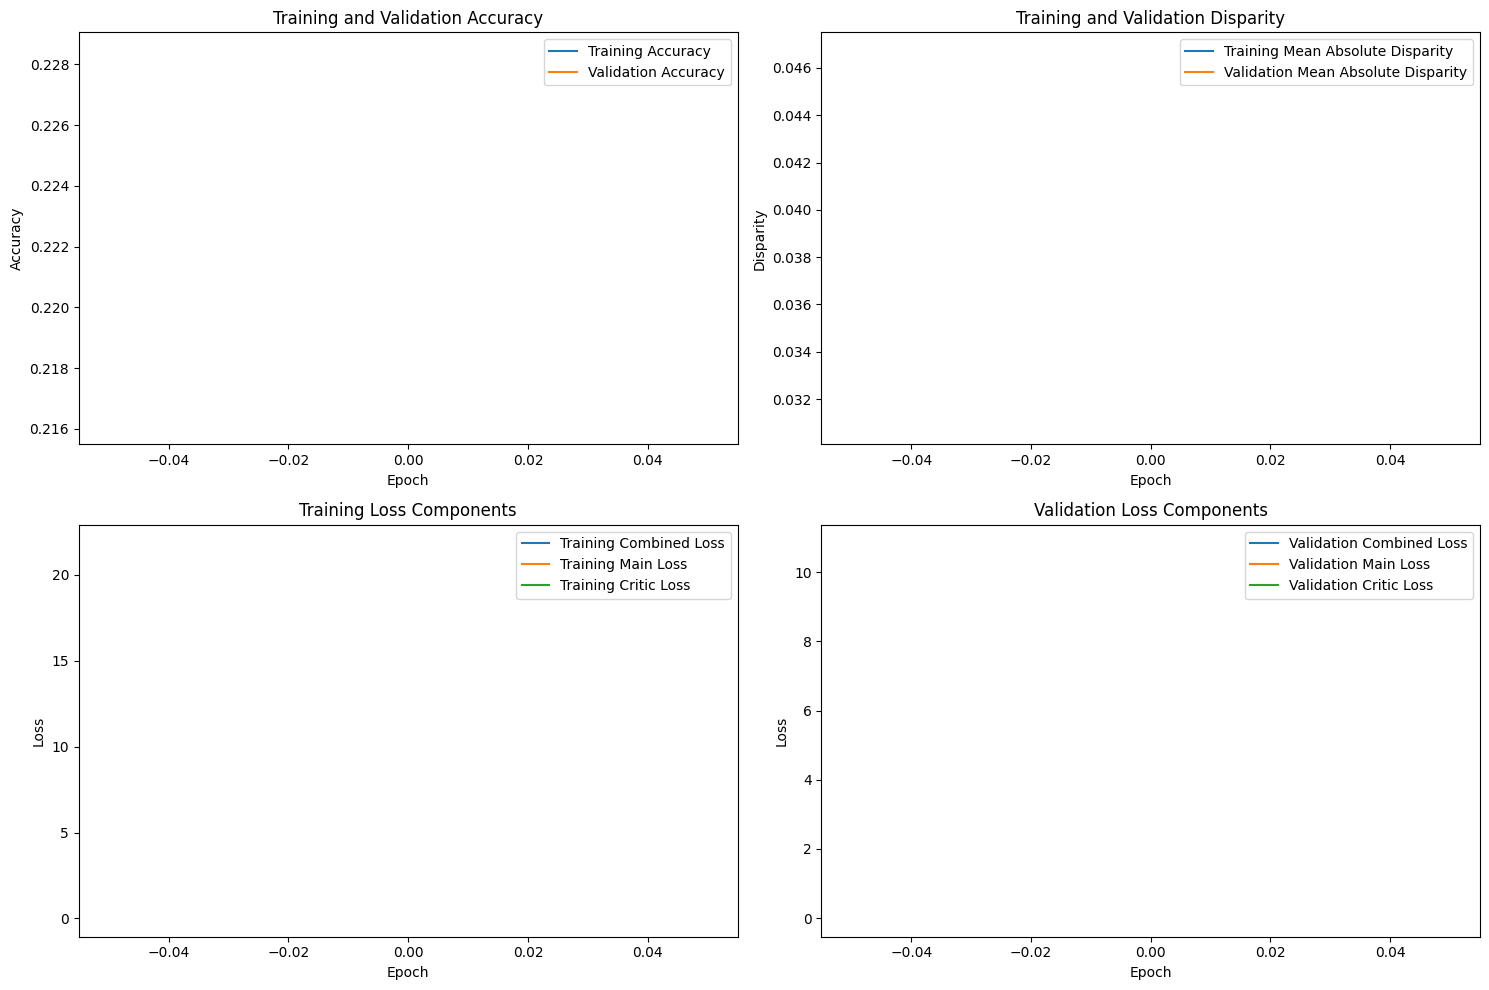

Epoch 2/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.29it/s]



Lambda 100 - Epoch 2 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.220120, VALIDATION Accuracy: 0.2461
TRAINING Disparity: 0.053036, VALIDATION Disparity: 0.0791
TRAINING Combined Loss: 4.637350, VALIDATION Combined Loss: 3.5013
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.10665935497138157
Class Celebration: Val Disparity = -0.005
Class Parade: Val Disparity = 0.01420454545454547
Class Waiter_Or_Waitress: Val Disparity = 0.0
Class Individual_Sports: Val Disparity = 0.14103464419475664
Class Surgeons: Val Disparity = 0.0
Class Spa: Val Disparity = 0.0
Class Law_Enforcement: Val Disparity = 0.09999999999999998
Class Business: Val Disparity = 0.0
Class Dresses: Val Disparity = 0.0
Class Water_Activities: Val Disparity = 0.061954439003619355
Class Picnic: Val Disparity = 0.0
Class Rescue: Val Disparity = -0.13155080213903741
Class Cheering: Val Disparity = -0.07201309328968902
Class Performance_And_Entertainme

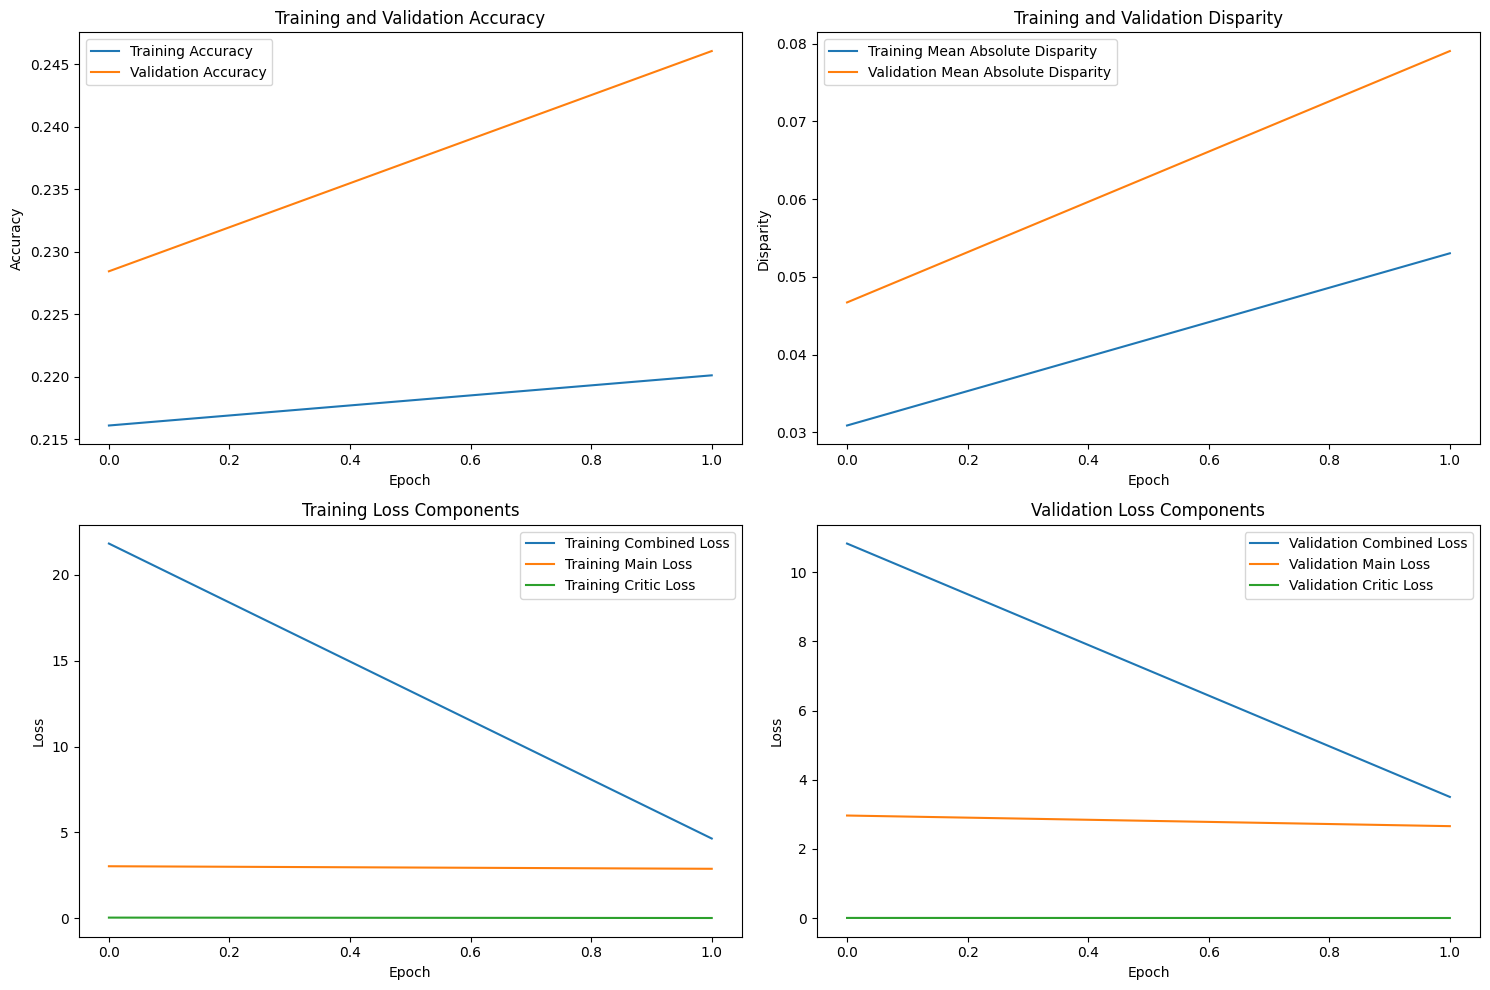

Epoch 3/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.24it/s]



Lambda 100 - Epoch 3 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.255883, VALIDATION Accuracy: 0.2699
TRAINING Disparity: 0.051705, VALIDATION Disparity: 0.0622
TRAINING Combined Loss: 3.125819, VALIDATION Combined Loss: 2.5790
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.019513086792107837
Class Celebration: Val Disparity = -0.015297029702970297
Class Parade: Val Disparity = 0.029356060606060497
Class Waiter_Or_Waitress: Val Disparity = 0.0
Class Individual_Sports: Val Disparity = 0.17759051186017477
Class Surgeons: Val Disparity = 0.0
Class Spa: Val Disparity = 0.0
Class Law_Enforcement: Val Disparity = 0.13145539906103287
Class Business: Val Disparity = 0.0
Class Dresses: Val Disparity = 0.0
Class Water_Activities: Val Disparity = 0.05982542048115819
Class Picnic: Val Disparity = 0.0
Class Rescue: Val Disparity = -0.08850267379679144
Class Cheering: Val Disparity = -0.02332242225859247
Class Performance

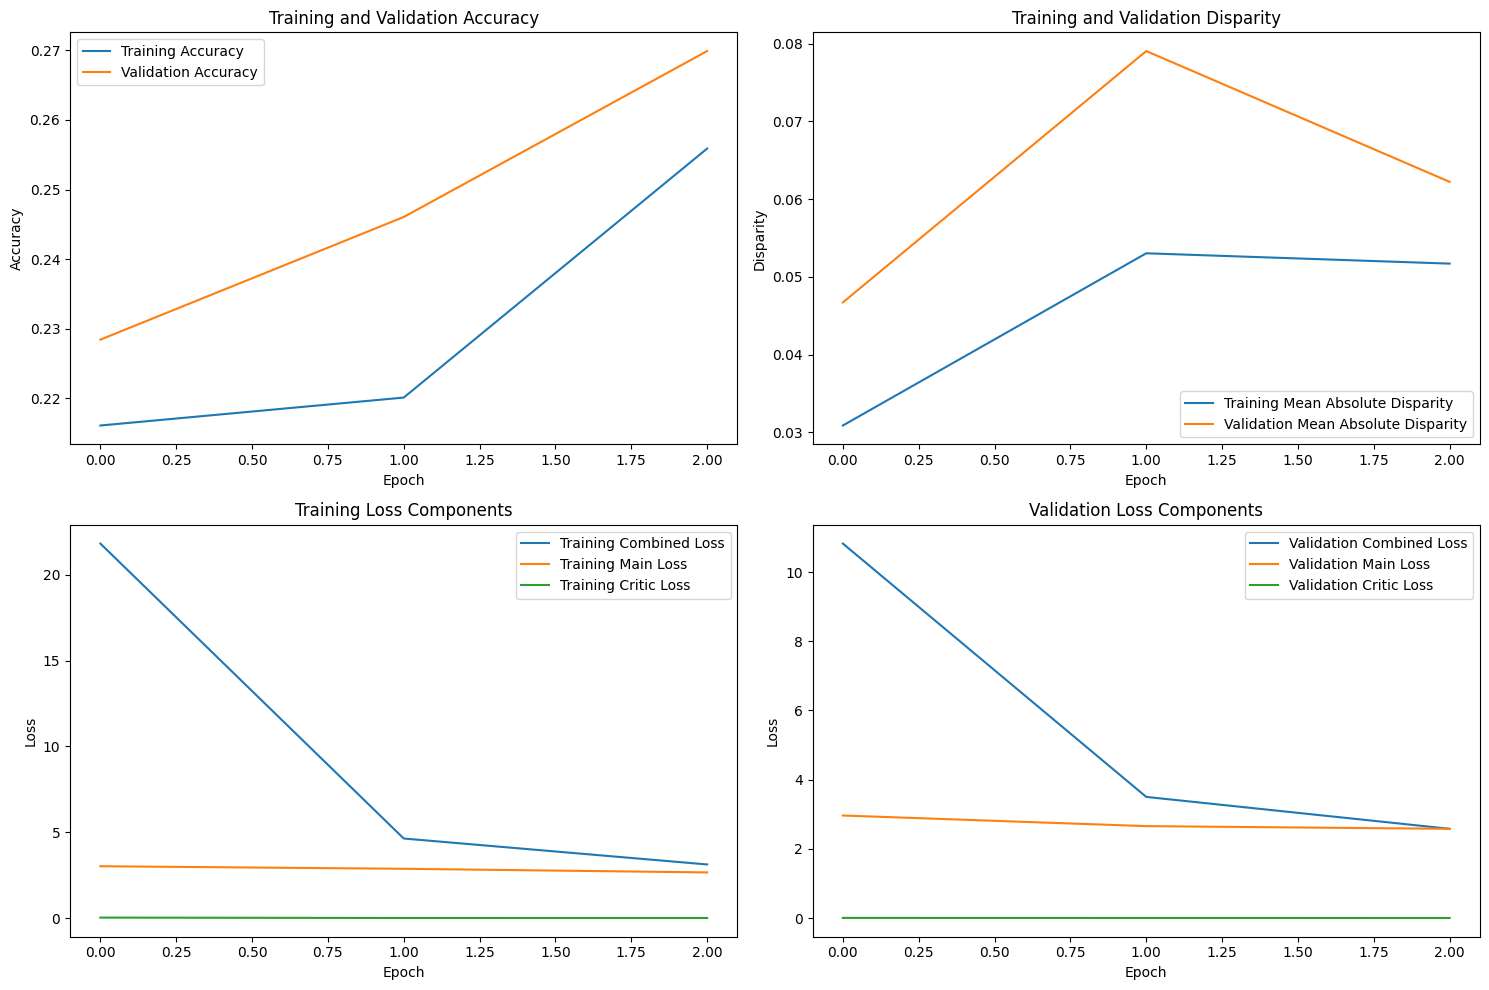

Epoch 4/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.33it/s]



Lambda 100 - Epoch 4 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.300559, VALIDATION Accuracy: 0.3210
TRAINING Disparity: 0.040775, VALIDATION Disparity: 0.0534
TRAINING Combined Loss: 2.408168, VALIDATION Combined Loss: 2.2571
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.04166523860118132
Class Celebration: Val Disparity = -0.11198019801980191
Class Parade: Val Disparity = -0.017992424242424088
Class Waiter_Or_Waitress: Val Disparity = 0.006109201985490649
Class Individual_Sports: Val Disparity = 0.06628433208489387
Class Surgeons: Val Disparity = 0.0
Class Spa: Val Disparity = 0.0
Class Law_Enforcement: Val Disparity = 0.14037558685446005
Class Business: Val Disparity = 0.0
Class Dresses: Val Disparity = -0.029940119760479045
Class Water_Activities: Val Disparity = 0.006387055567383393
Class Picnic: Val Disparity = 0.0
Class Rescue: Val Disparity = 0.012566844919786106
Class Cheering: Val Disparity = -0.

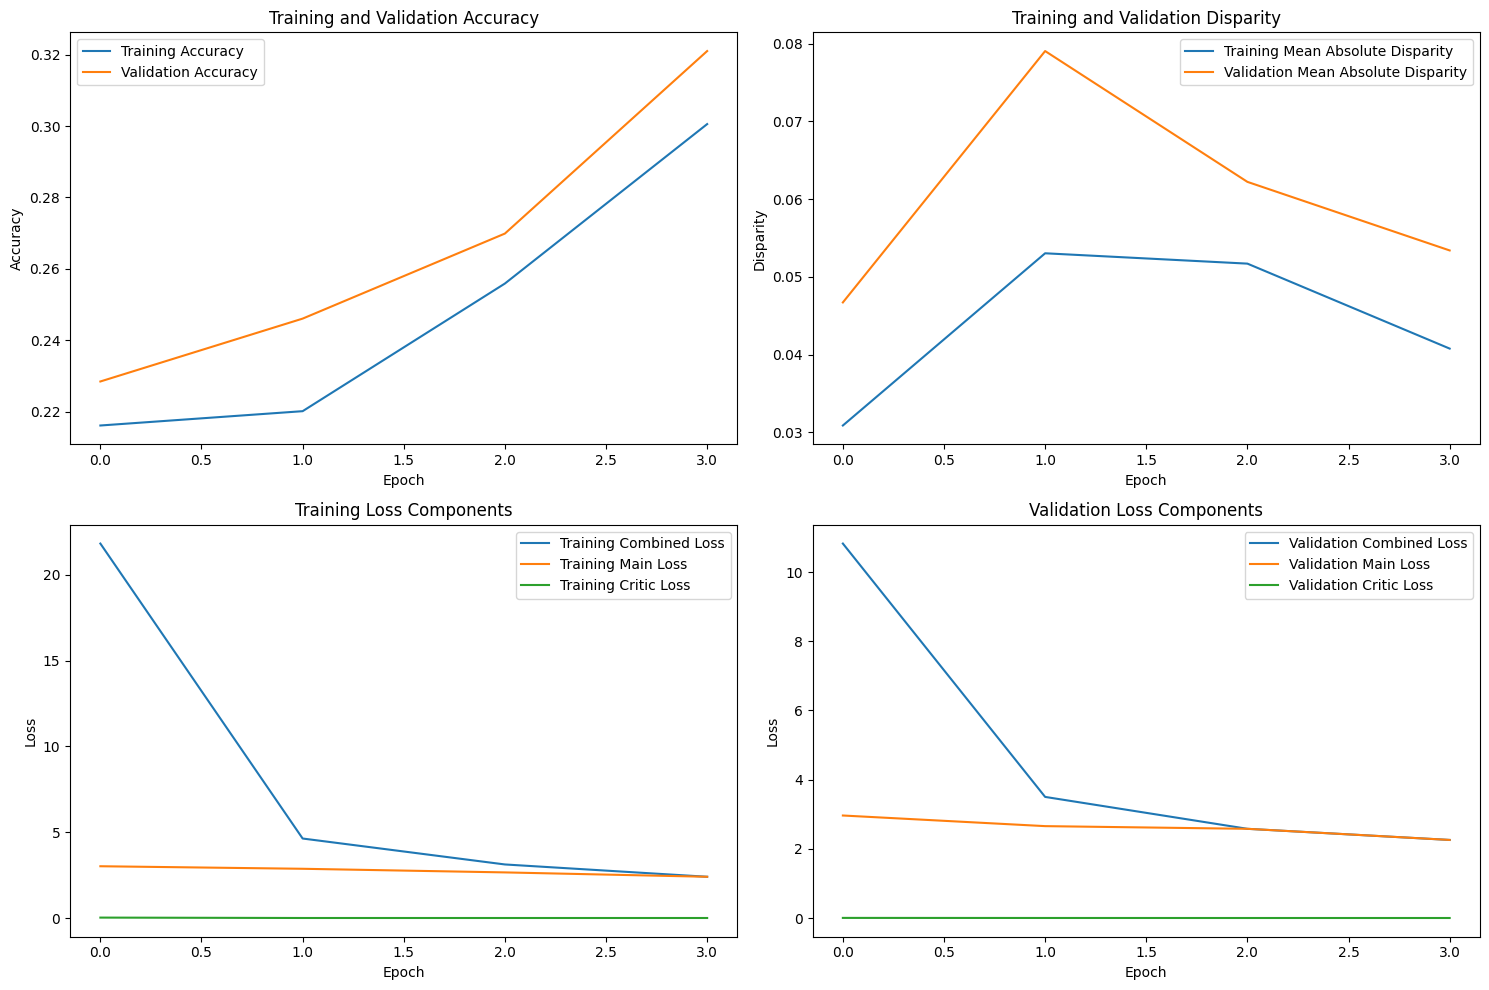

Epoch 5/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.30it/s]



Lambda 100 - Epoch 5 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.327334, VALIDATION Accuracy: 0.3372
TRAINING Disparity: 0.049670, VALIDATION Disparity: 0.0703
TRAINING Combined Loss: 2.250513, VALIDATION Combined Loss: 2.1529
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.0855582593595412
Class Celebration: Val Disparity = -0.052574257425742565
Class Parade: Val Disparity = 0.003787878787878729
Class Waiter_Or_Waitress: Val Disparity = -0.07636502481863307
Class Individual_Sports: Val Disparity = 0.07077091136079905
Class Surgeons: Val Disparity = 0.0
Class Spa: Val Disparity = 0.0
Class Law_Enforcement: Val Disparity = 0.11478873239436621
Class Business: Val Disparity = 0.0
Class Dresses: Val Disparity = -0.17365269461077845
Class Water_Activities: Val Disparity = -0.0011709601873535203
Class Picnic: Val Disparity = 0.0
Class Rescue: Val Disparity = -0.022727272727272728
Class Cheering: Val Disparity = -0

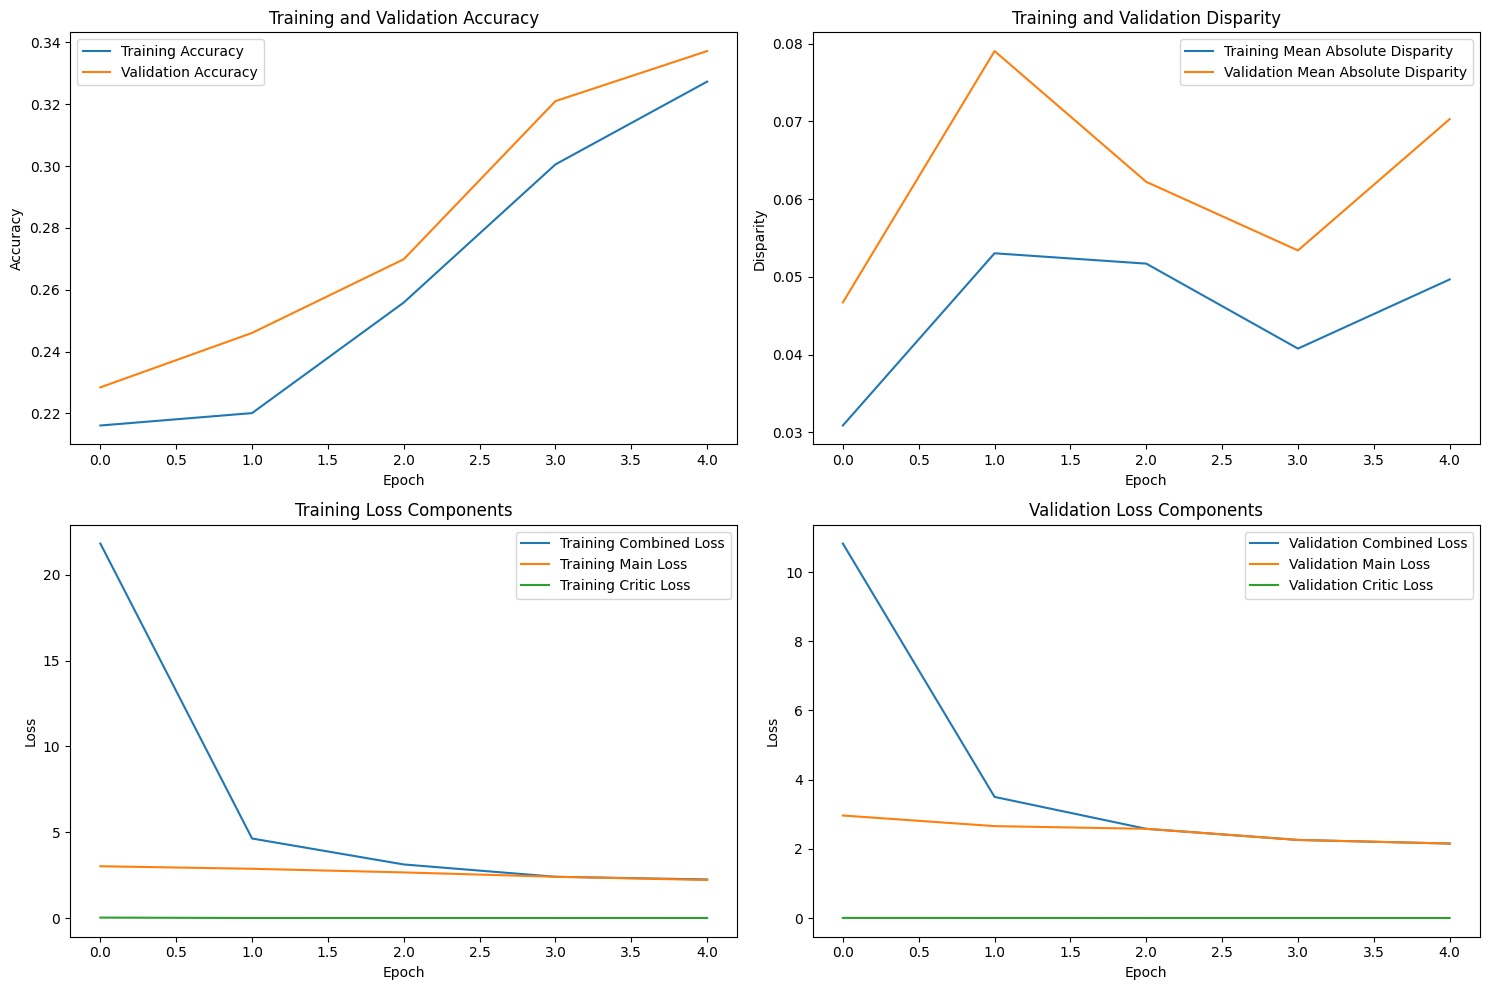

Epoch 6/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.31it/s]



Lambda 100 - Epoch 6 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.355826, VALIDATION Accuracy: 0.3764
TRAINING Disparity: 0.059232, VALIDATION Disparity: 0.0736
TRAINING Combined Loss: 2.126694, VALIDATION Combined Loss: 2.0370
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.030389233528692605
Class Celebration: Val Disparity = -0.07207920792079206
Class Parade: Val Disparity = 0.028409090909090995
Class Waiter_Or_Waitress: Val Disparity = -0.08896525391370752
Class Individual_Sports: Val Disparity = 0.005422908863920162
Class Surgeons: Val Disparity = 0.0
Class Spa: Val Disparity = 0.0
Class Law_Enforcement: Val Disparity = 0.14483568075117365
Class Business: Val Disparity = -0.02320877249015224
Class Dresses: Val Disparity = -0.3353293413173652
Class Water_Activities: Val Disparity = -0.018203108367042642
Class Picnic: Val Disparity = 0.0
Class Rescue: Val Disparity = -0.010962566844919787
Class Cheering: V

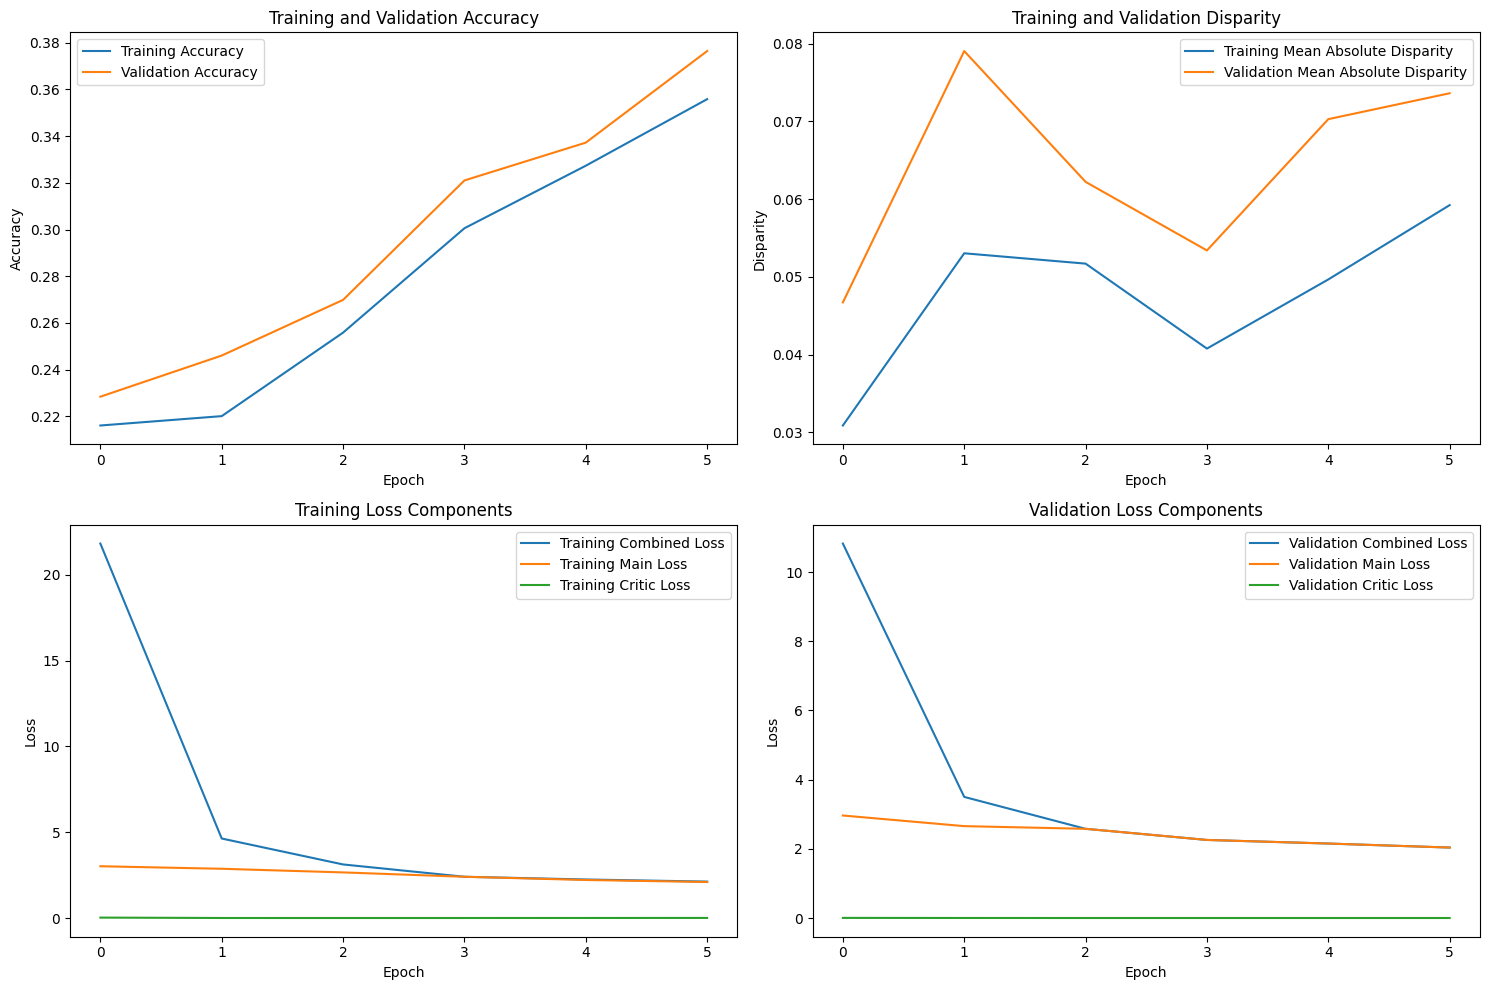

Epoch 7/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.26it/s]



Lambda 100 - Epoch 7 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.384877, VALIDATION Accuracy: 0.4091
TRAINING Disparity: 0.071351, VALIDATION Disparity: 0.0922
TRAINING Combined Loss: 2.003638, VALIDATION Combined Loss: 1.9447
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.027396008271355243
Class Celebration: Val Disparity = -0.10757425742574267
Class Parade: Val Disparity = 0.03598484848484862
Class Waiter_Or_Waitress: Val Disparity = -0.09736540664375715
Class Individual_Sports: Val Disparity = 0.01583957553058679
Class Surgeons: Val Disparity = 0.0
Class Spa: Val Disparity = 0.0
Class Law_Enforcement: Val Disparity = 0.16784037558685433
Class Business: Val Disparity = -0.0011710848504205285
Class Dresses: Val Disparity = -0.47305389221556887
Class Water_Activities: Val Disparity = -0.01958697040664259
Class Picnic: Val Disparity = 0.0
Class Rescue: Val Disparity = 0.0008021390374331576
Class Cheering: V

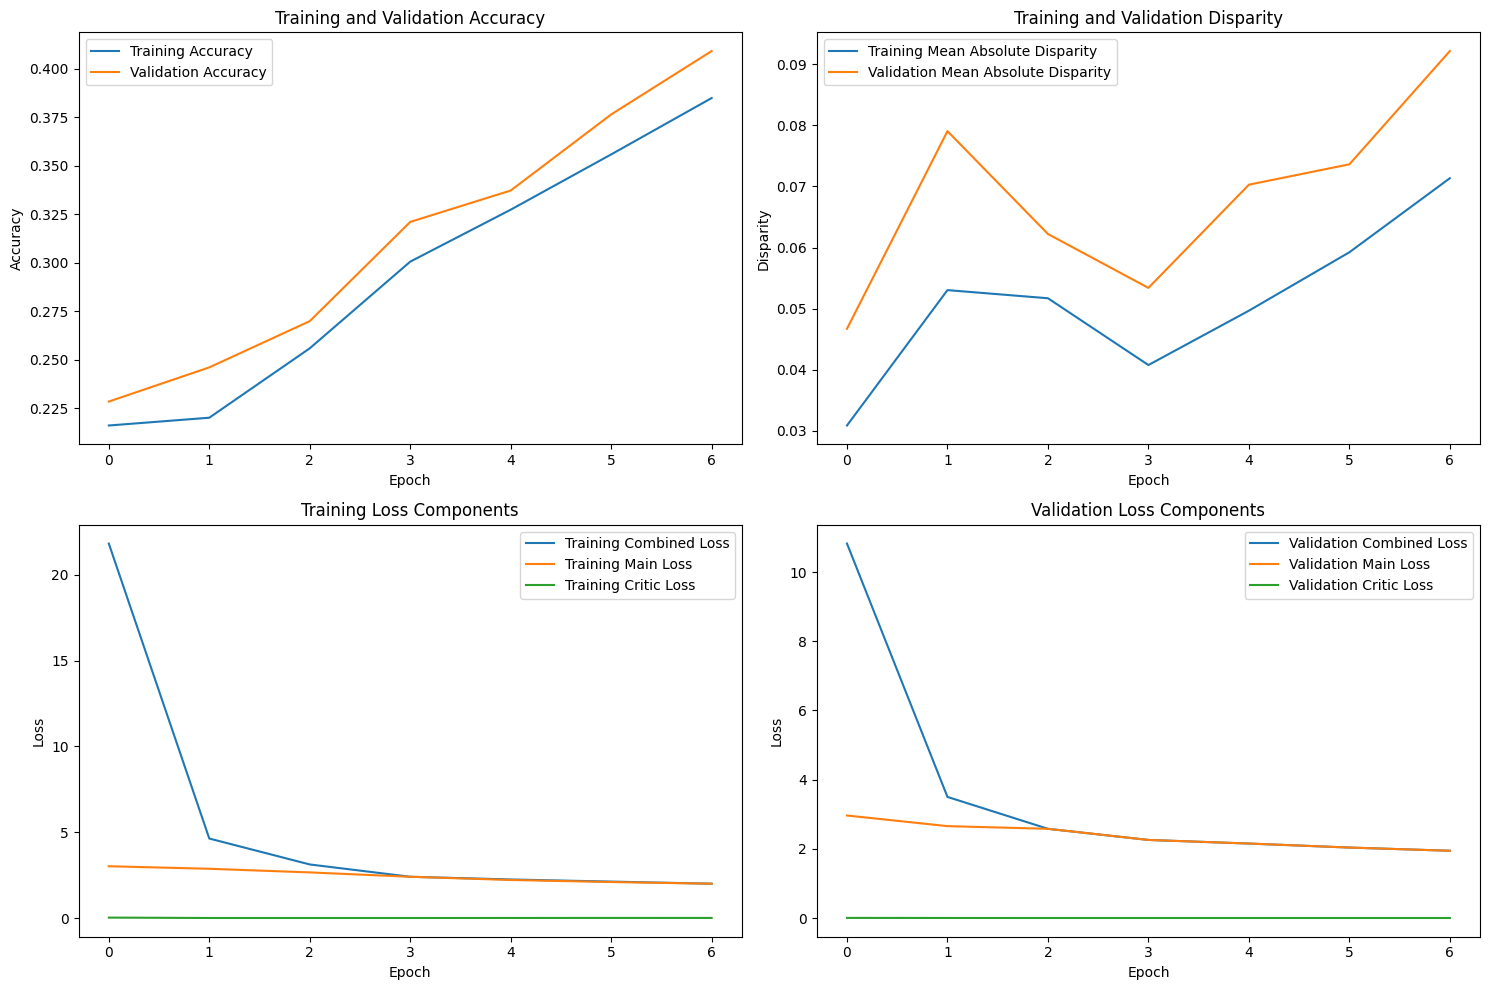

Epoch 8/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.31it/s]



Lambda 100 - Epoch 8 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.418306, VALIDATION Accuracy: 0.4375
TRAINING Disparity: 0.086679, VALIDATION Disparity: 0.0893
TRAINING Combined Loss: 1.912790, VALIDATION Combined Loss: 1.8698
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.051238989615107866
Class Celebration: Val Disparity = -0.023267326732673344
Class Parade: Val Disparity = 0.03882575757575757
Class Waiter_Or_Waitress: Val Disparity = -0.0954562810232914
Class Individual_Sports: Val Disparity = 0.006242197253433224
Class Surgeons: Val Disparity = 0.0
Class Spa: Val Disparity = 0.0
Class Law_Enforcement: Val Disparity = 0.1652582159624414
Class Business: Val Disparity = 0.030767592888321094
Class Dresses: Val Disparity = -0.42015968063872255
Class Water_Activities: Val Disparity = 0.005003193527783667
Class Picnic: Val Disparity = 0.0
Class Rescue: Val Disparity = -0.010962566844919783
Class Cheering: Val

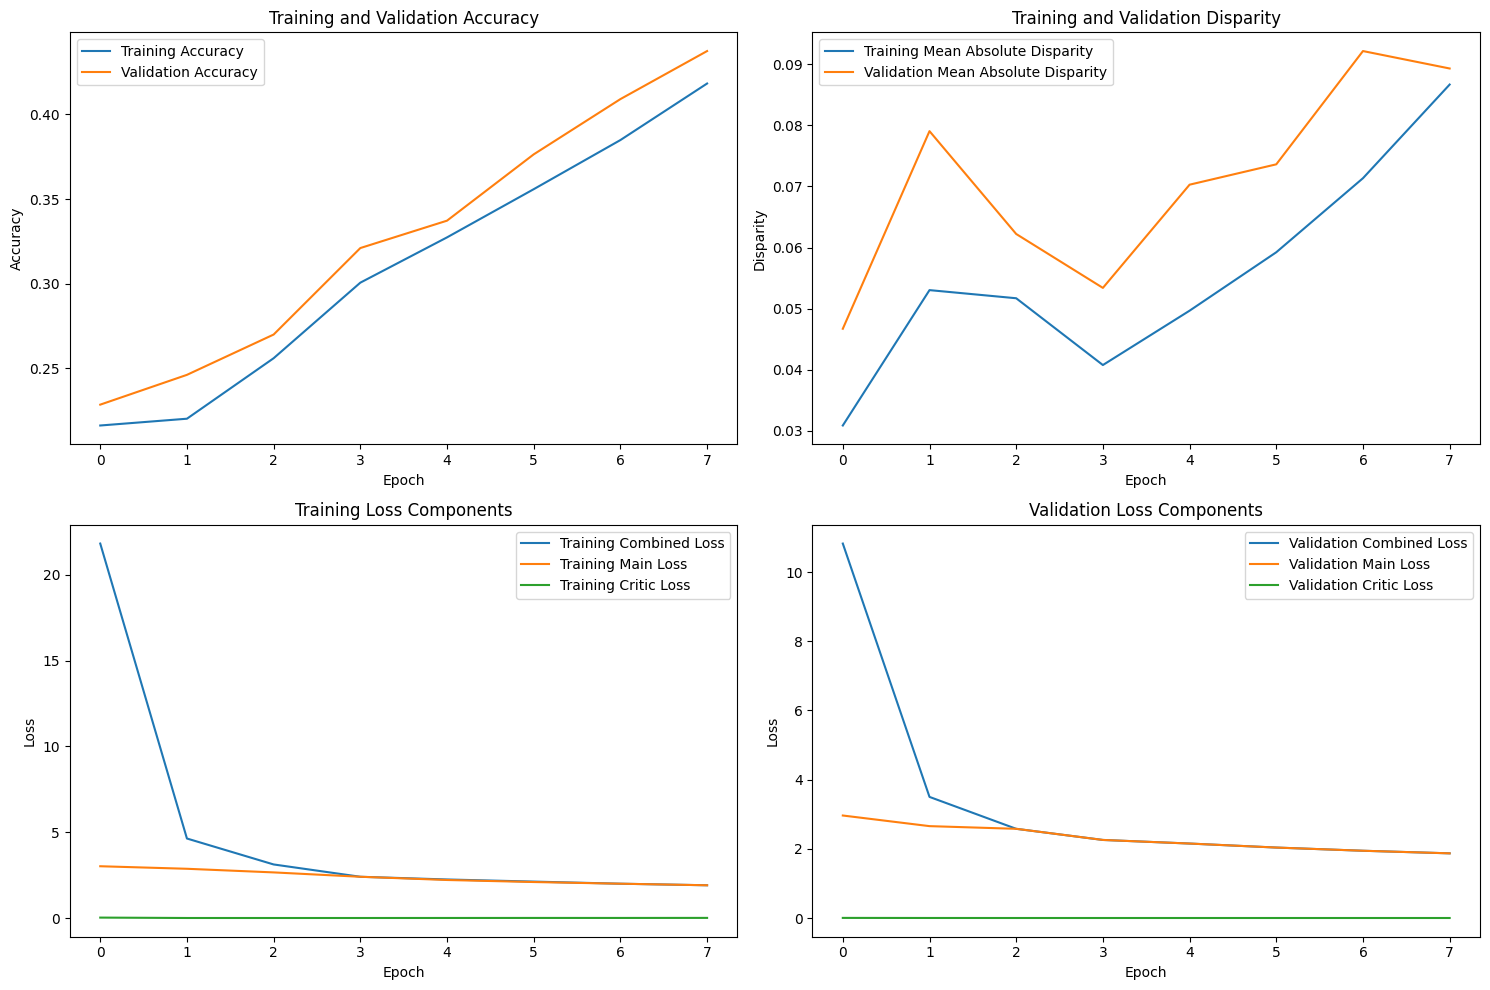

Epoch 9/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.25it/s]



Lambda 100 - Epoch 9 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.437519, VALIDATION Accuracy: 0.4537
TRAINING Disparity: 0.094424, VALIDATION Disparity: 0.0890
TRAINING Combined Loss: 1.838907, VALIDATION Combined Loss: 1.8045
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.05492911082930618
Class Celebration: Val Disparity = -0.0380693069306931
Class Parade: Val Disparity = 0.03125
Class Waiter_Or_Waitress: Val Disparity = -0.1221840397098129
Class Individual_Sports: Val Disparity = -0.006008114856429492
Class Surgeons: Val Disparity = 0.0
Class Spa: Val Disparity = -0.020833333333333332
Class Law_Enforcement: Val Disparity = 0.16971830985915487
Class Business: Val Disparity = -0.01394655594591715
Class Dresses: Val Disparity = -0.44411177644710587
Class Water_Activities: Val Disparity = 0.016606344475196932
Class Picnic: Val Disparity = 0.0718954248366013
Class Rescue: Val Disparity = -0.022727272727272728

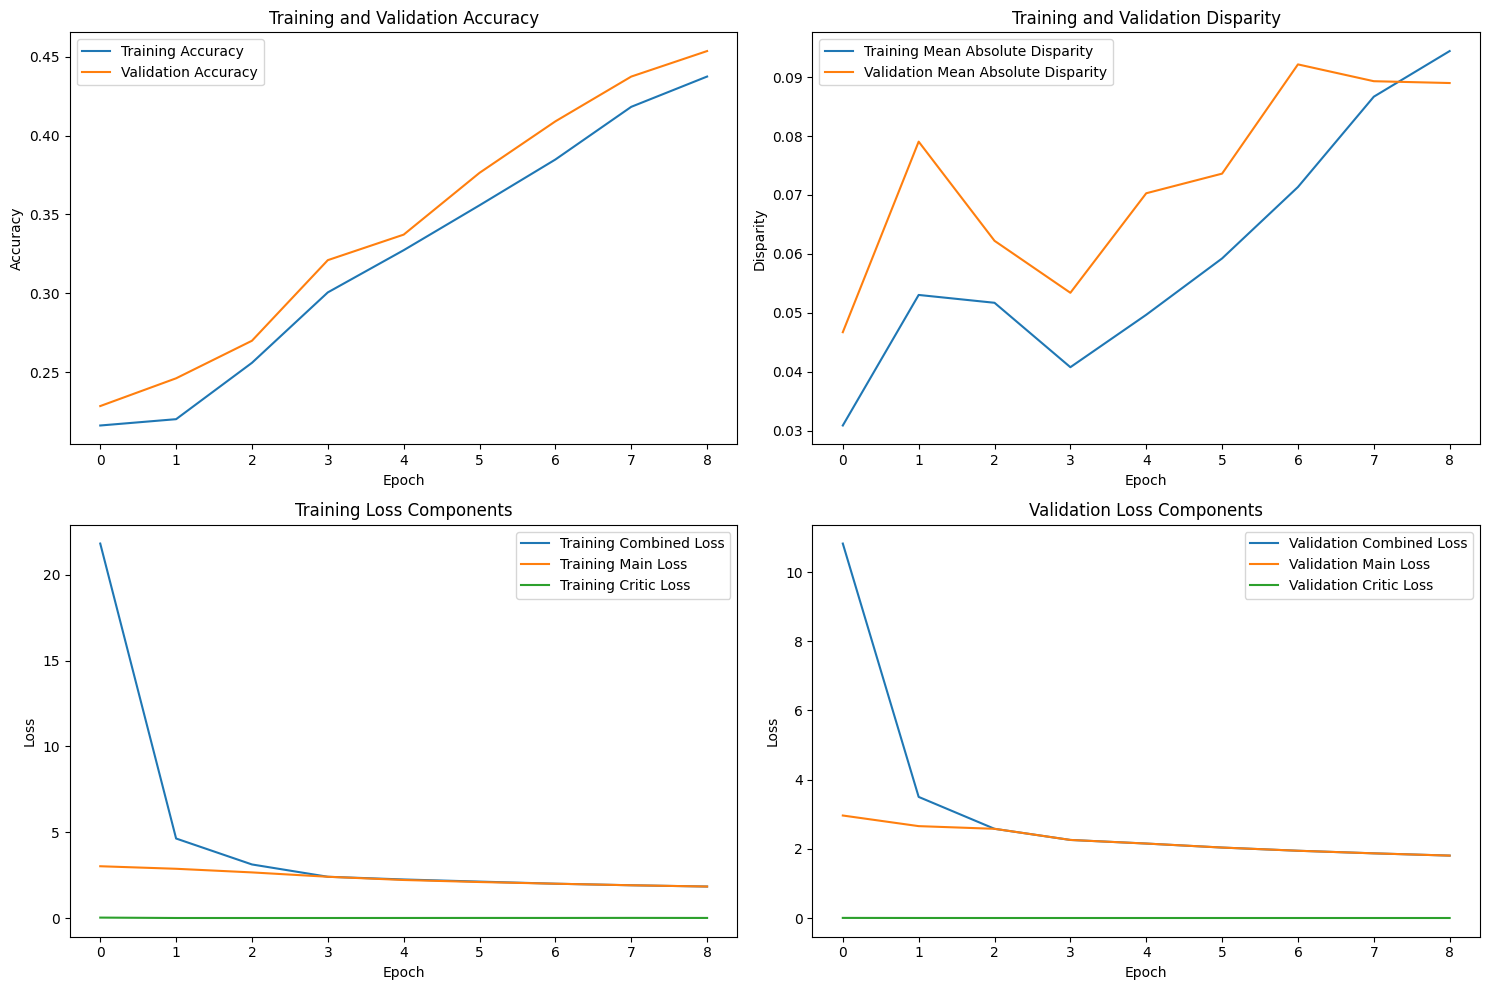

Epoch 10/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.26it/s]



Lambda 100 - Epoch 10 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.455691, VALIDATION Accuracy: 0.4767
TRAINING Disparity: 0.085241, VALIDATION Disparity: 0.1083
TRAINING Combined Loss: 1.762069, VALIDATION Combined Loss: 1.7414
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.07932046931944114
Class Celebration: Val Disparity = -0.03366336633663369
Class Parade: Val Disparity = 0.013257575757575912
Class Waiter_Or_Waitress: Val Disparity = -0.13669339442535322
Class Individual_Sports: Val Disparity = -0.049313358302122356
Class Surgeons: Val Disparity = 0.0
Class Spa: Val Disparity = -0.06250000000000001
Class Law_Enforcement: Val Disparity = 0.21009389671361495
Class Business: Val Disparity = 0.03385499840306616
Class Dresses: Val Disparity = -0.45608782435129747
Class Water_Activities: Val Disparity = 0.037790078773685454
Class Picnic: Val Disparity = 0.1241830065359477
Class Rescue: Val Disparity = -0.0227

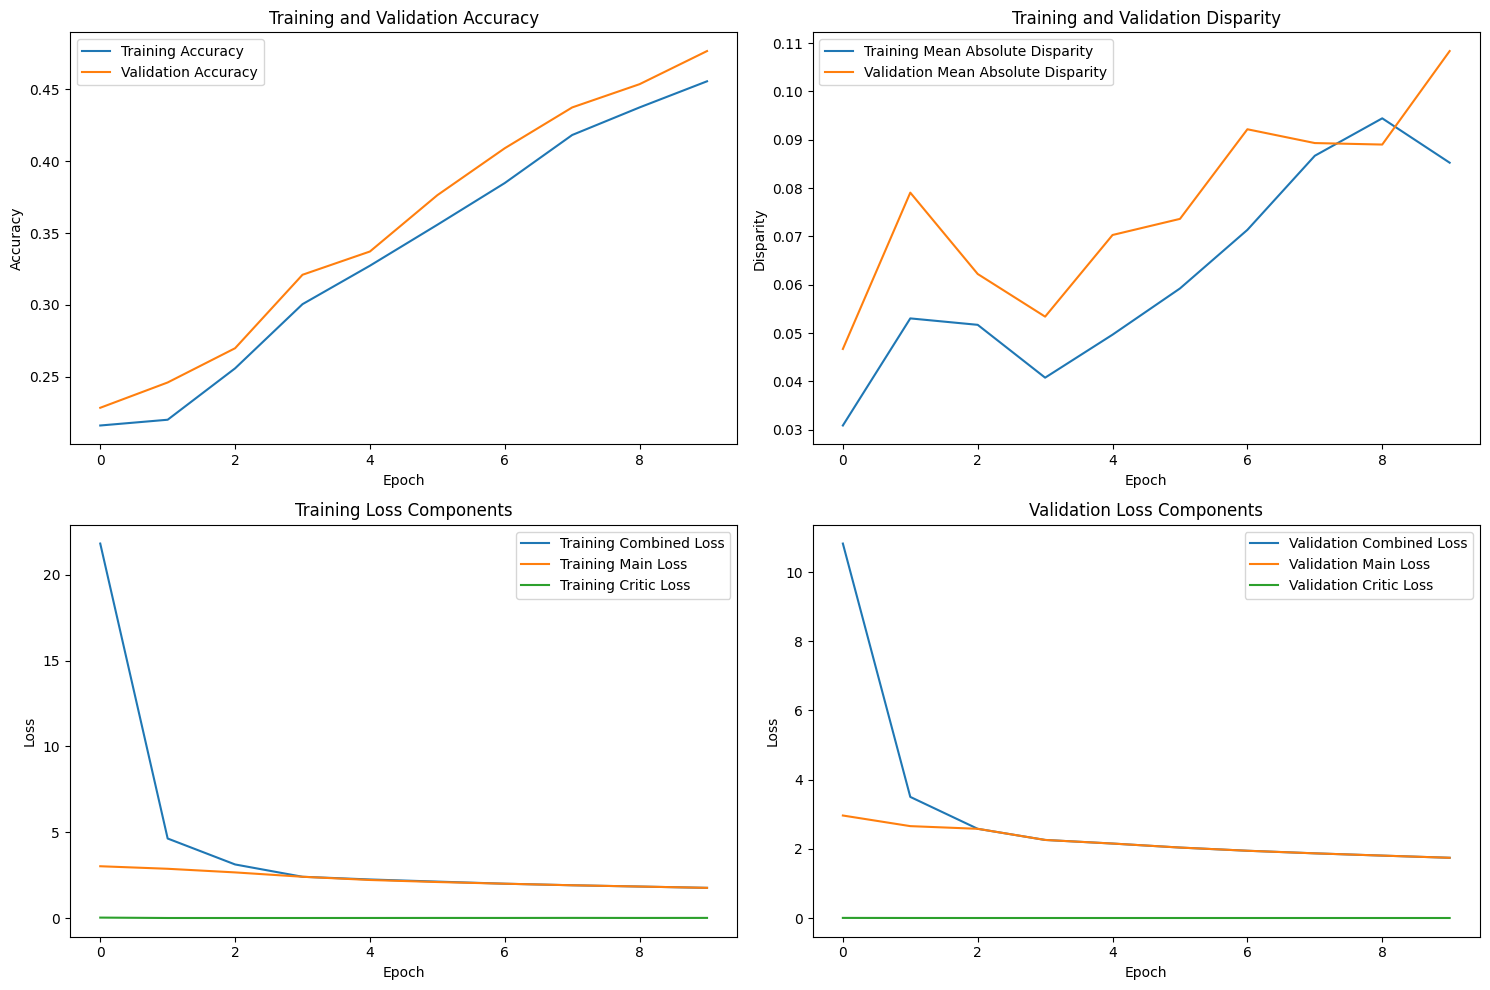

Epoch 11/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.27it/s]



Lambda 100 - Epoch 11 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.478781, VALIDATION Accuracy: 0.4830
TRAINING Disparity: 0.082099, VALIDATION Disparity: 0.0930
TRAINING Combined Loss: 1.696028, VALIDATION Combined Loss: 1.6862
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.0956803875198502
Class Celebration: Val Disparity = -0.06287128712871293
Class Parade: Val Disparity = 0.02367424242424243
Class Waiter_Or_Waitress: Val Disparity = -0.14280259641084386
Class Individual_Sports: Val Disparity = -0.06585518102372034
Class Surgeons: Val Disparity = 0.024390243902439025
Class Spa: Val Disparity = -0.14583333333333331
Class Law_Enforcement: Val Disparity = 0.19530516431924883
Class Business: Val Disparity = -0.010859150431172138
Class Dresses: Val Disparity = -0.3253493013972056
Class Water_Activities: Val Disparity = 0.04800936768149877
Class Picnic: Val Disparity = -0.0326797385620915
Class Rescue: Val Disp

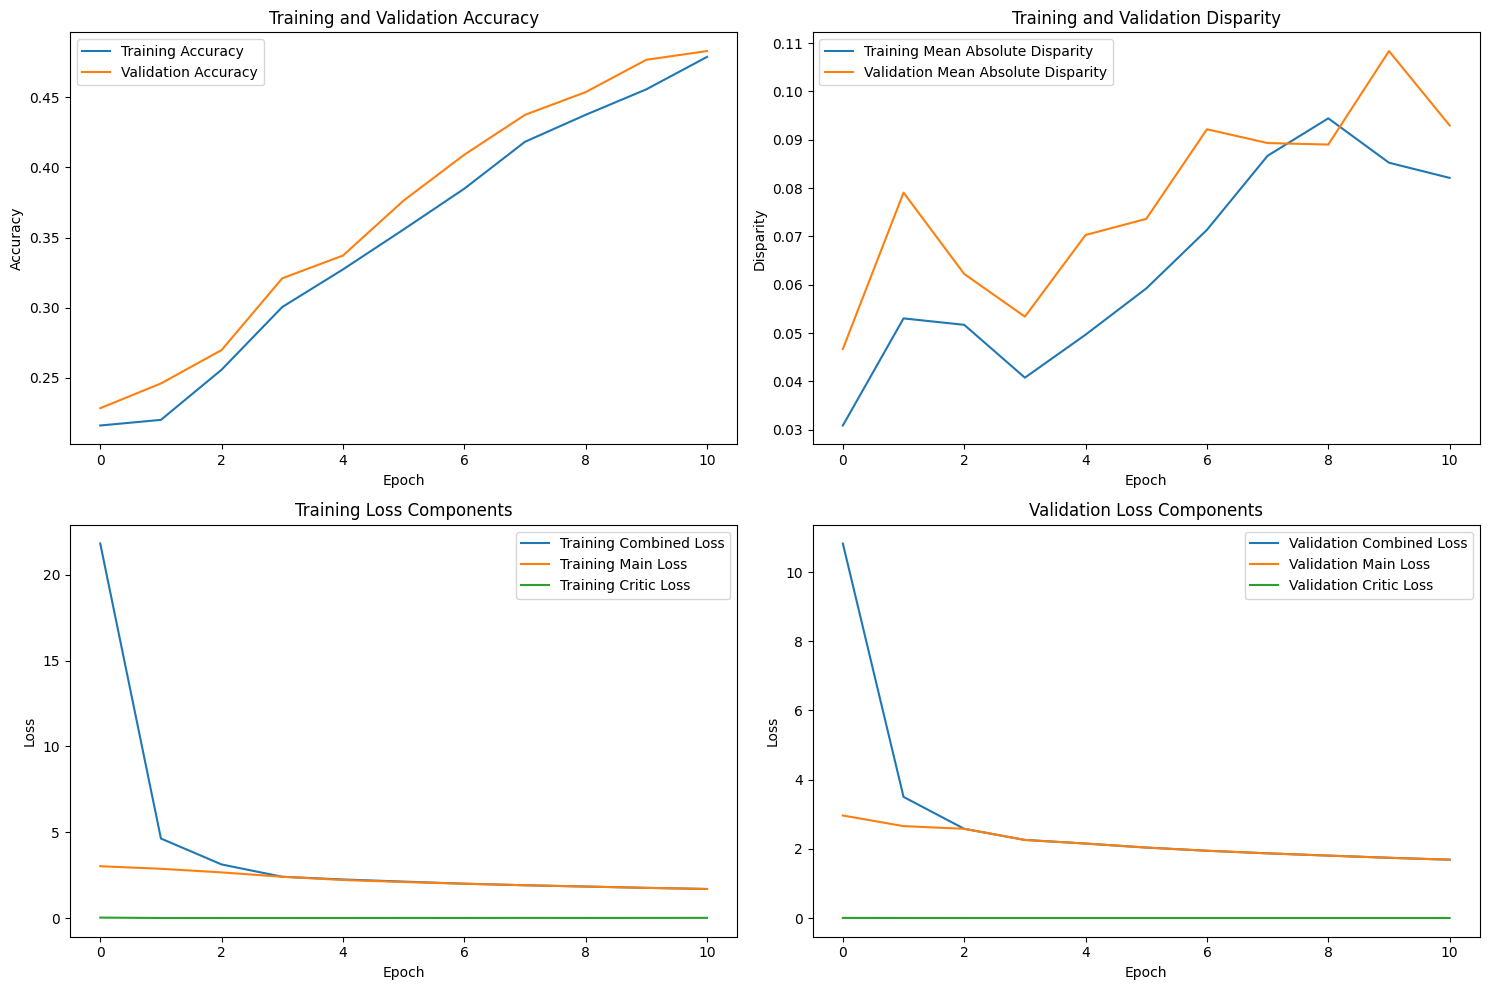

Epoch 12/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.25it/s]



Lambda 100 - Epoch 12 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.499556, VALIDATION Accuracy: 0.4989
TRAINING Disparity: 0.091247, VALIDATION Disparity: 0.1002
TRAINING Combined Loss: 1.622773, VALIDATION Combined Loss: 1.6315
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.08450720316230809
Class Celebration: Val Disparity = -0.03866336633663364
Class Parade: Val Disparity = 0.027462121212121215
Class Waiter_Or_Waitress: Val Disparity = -0.198549064528446
Class Individual_Sports: Val Disparity = -0.0832162921348315
Class Surgeons: Val Disparity = -0.03621581670362158
Class Spa: Val Disparity = -0.16666666666666666
Class Law_Enforcement: Val Disparity = 0.19788732394366187
Class Business: Val Disparity = -0.0431172149473012
Class Dresses: Val Disparity = -0.33133732534930144
Class Water_Activities: Val Disparity = 0.05418352139663618
Class Picnic: Val Disparity = 0.0
Class Rescue: Val Disparity = -0.0227272

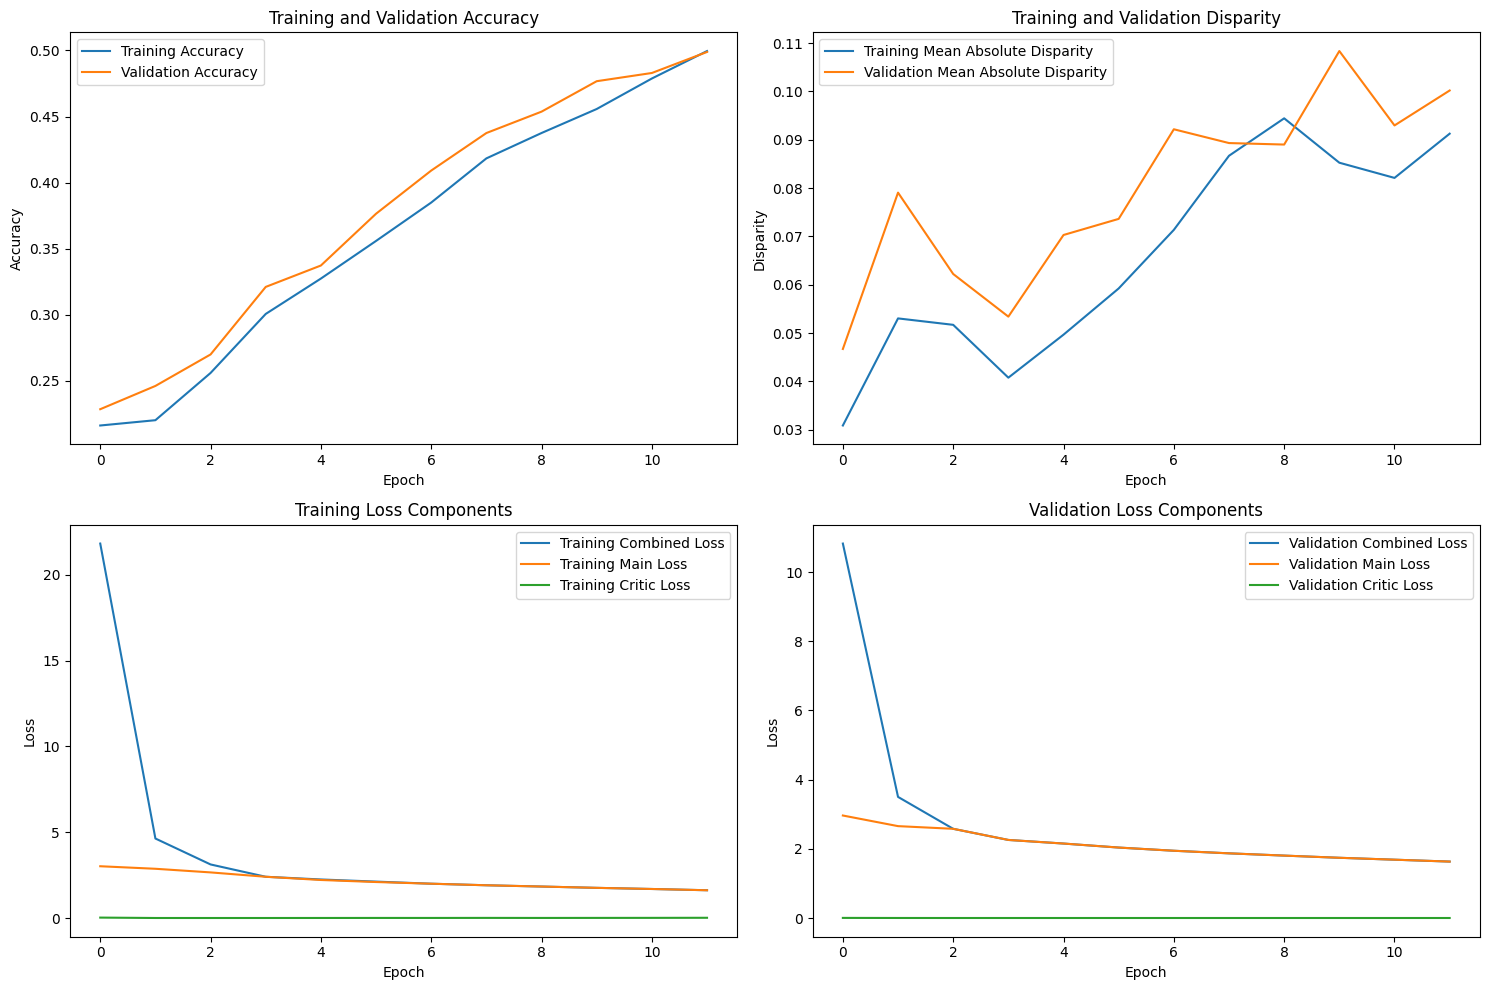

Epoch 13/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.28it/s]



Lambda 100 - Epoch 13 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.516956, VALIDATION Accuracy: 0.5146
TRAINING Disparity: 0.092154, VALIDATION Disparity: 0.1180
TRAINING Combined Loss: 1.563714, VALIDATION Combined Loss: 1.5809
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.11014383475568634
Class Celebration: Val Disparity = -0.02846534653465338
Class Parade: Val Disparity = 0.046401515151514916
Class Waiter_Or_Waitress: Val Disparity = -0.2439862542955326
Class Individual_Sports: Val Disparity = -0.07627184769038708
Class Surgeons: Val Disparity = -0.017738359201773843
Class Spa: Val Disparity = -0.20833333333333331
Class Law_Enforcement: Val Disparity = 0.20492957746478874
Class Business: Val Disparity = -0.057276695411476675
Class Dresses: Val Disparity = -0.5039920159680639
Class Water_Activities: Val Disparity = 0.031615925058548267
Class Picnic: Val Disparity = -0.05882352941176472
Class Rescue: Val 

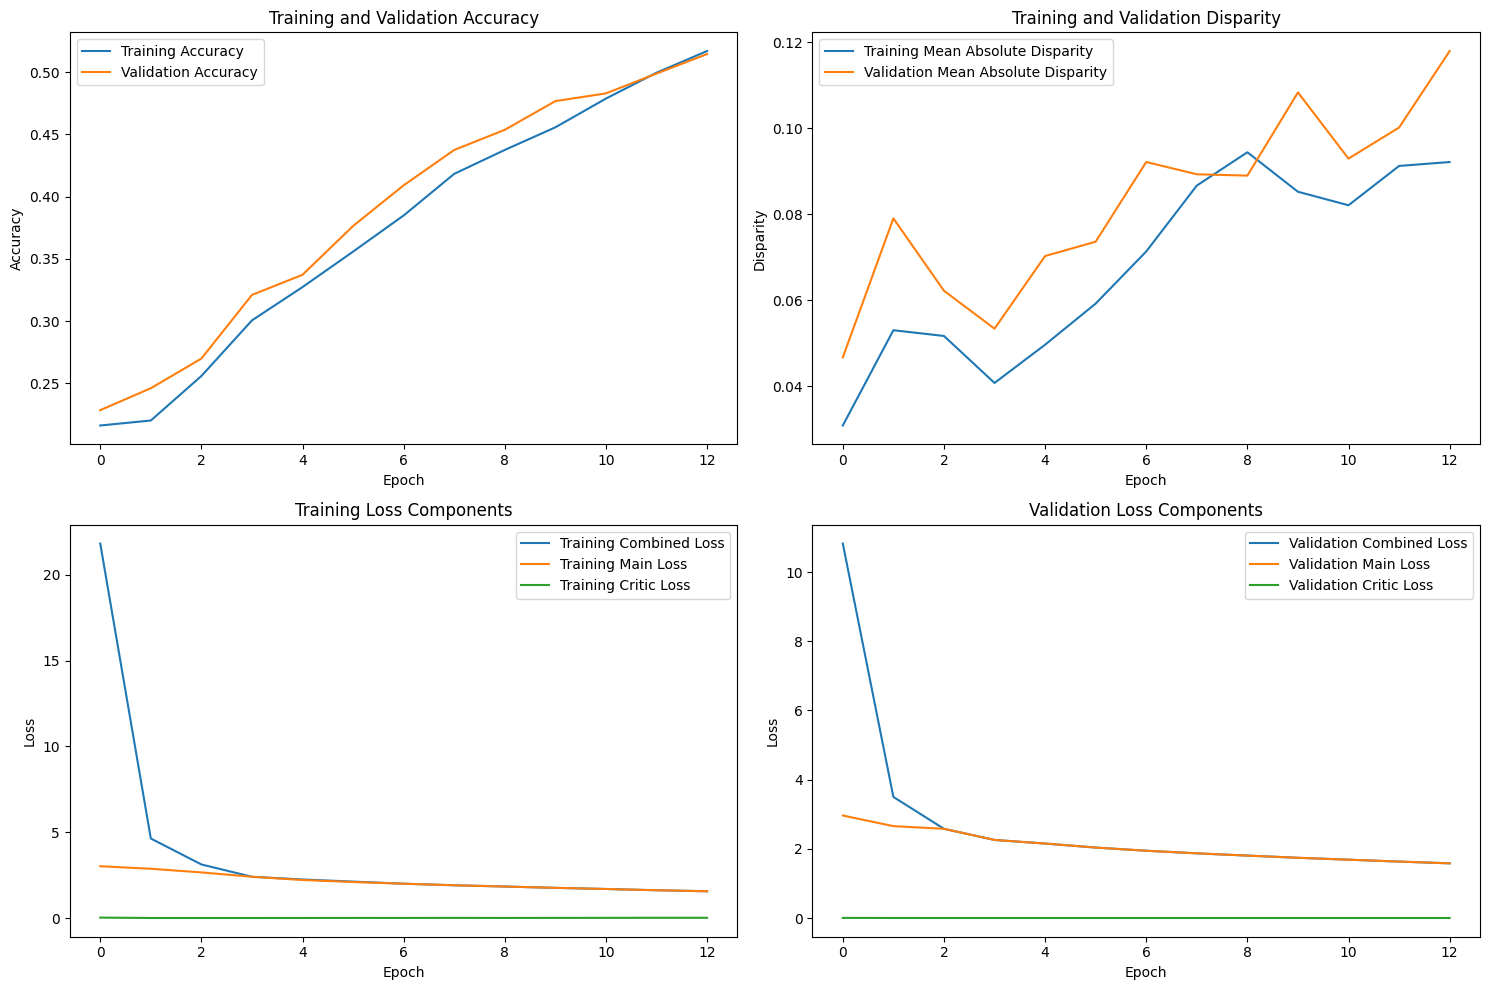

Epoch 14/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:17<00:00,  3.22it/s]



Lambda 100 - Epoch 14 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.538349, VALIDATION Accuracy: 0.5305
TRAINING Disparity: 0.099682, VALIDATION Disparity: 0.1276
TRAINING Combined Loss: 1.501873, VALIDATION Combined Loss: 1.5404
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.13698004135677633
Class Celebration: Val Disparity = -0.0435643564356436
Class Parade: Val Disparity = 0.05681818181818199
Class Waiter_Or_Waitress: Val Disparity = -0.2646048109965636
Class Individual_Sports: Val Disparity = -0.10241104868913864
Class Surgeons: Val Disparity = -0.02365114560236513
Class Spa: Val Disparity = -0.31249999999999994
Class Law_Enforcement: Val Disparity = 0.20492957746478863
Class Business: Val Disparity = -0.047375705312466765
Class Dresses: Val Disparity = -0.373253493013972
Class Water_Activities: Val Disparity = -0.018948264849904084
Class Picnic: Val Disparity = -0.09803921568627455
Class Rescue: Val Dis

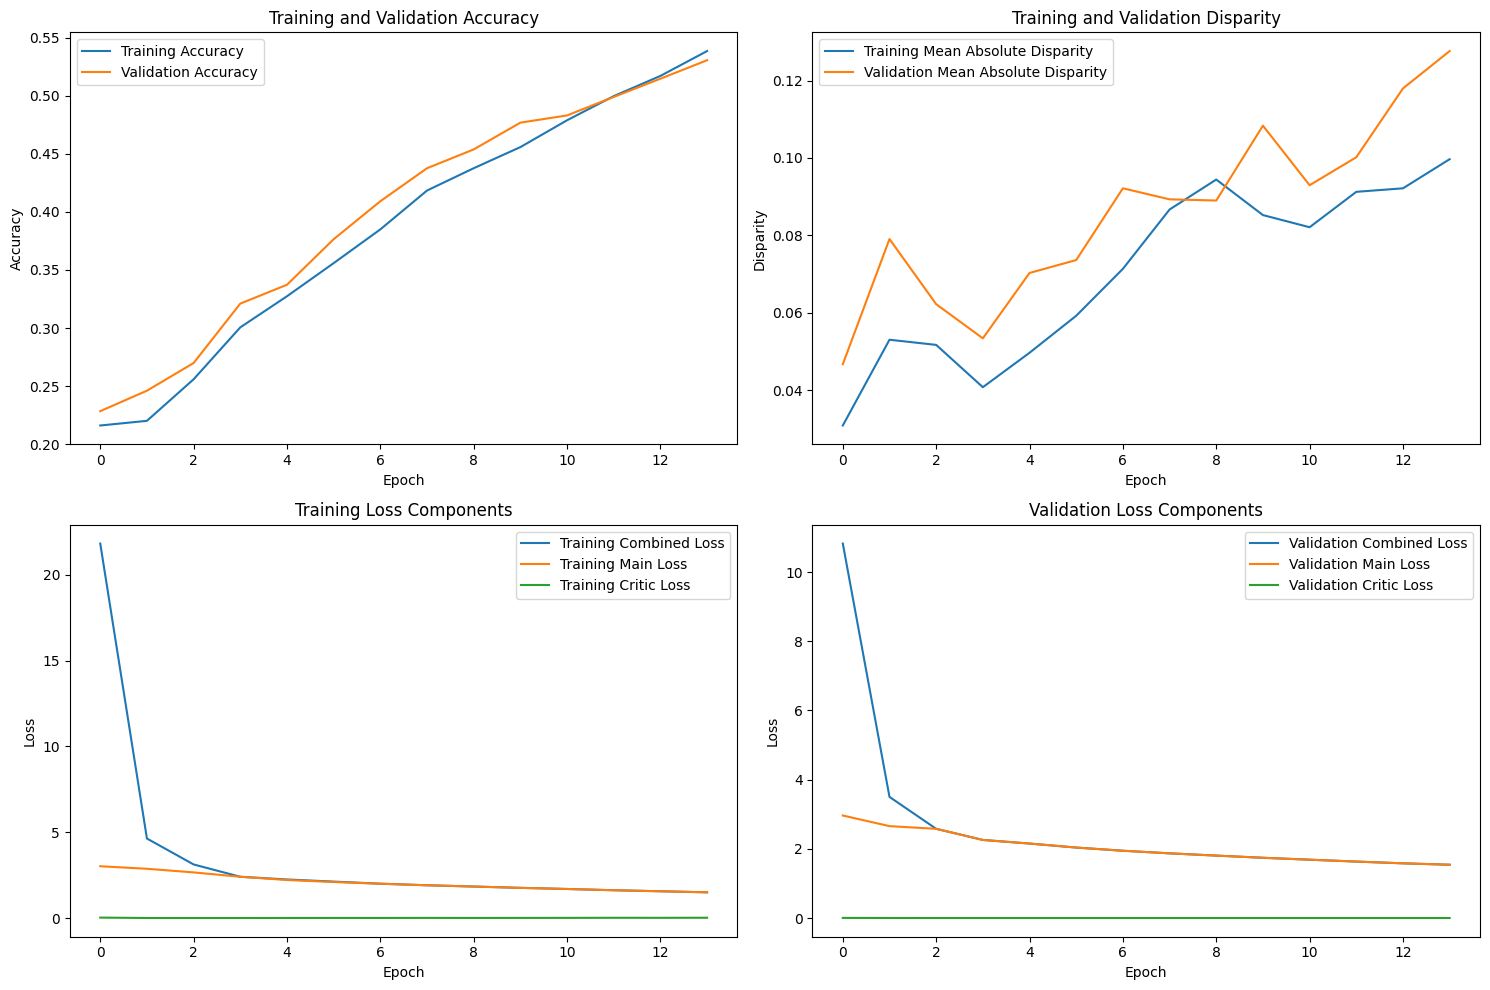

Epoch 15/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:17<00:00,  3.19it/s]



Lambda 100 - Epoch 15 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.563445, VALIDATION Accuracy: 0.5410
TRAINING Disparity: 0.103891, VALIDATION Disparity: 0.1496
TRAINING Combined Loss: 1.432802, VALIDATION Combined Loss: 1.4935
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.10645371354148803
Class Celebration: Val Disparity = -0.03396039603960399
Class Parade: Val Disparity = 0.004734848484848397
Class Waiter_Or_Waitress: Val Disparity = -0.27491408934707895
Class Individual_Sports: Val Disparity = -0.12324438202247179
Class Surgeons: Val Disparity = 0.07390983000739096
Class Spa: Val Disparity = -0.41666666666666663
Class Law_Enforcement: Val Disparity = 0.20492957746478863
Class Business: Val Disparity = -0.05983178963057595
Class Dresses: Val Disparity = -0.6407185628742516
Class Water_Activities: Val Disparity = 0.016606344475197043
Class Picnic: Val Disparity = -0.05882352941176472
Class Rescue: Val Di

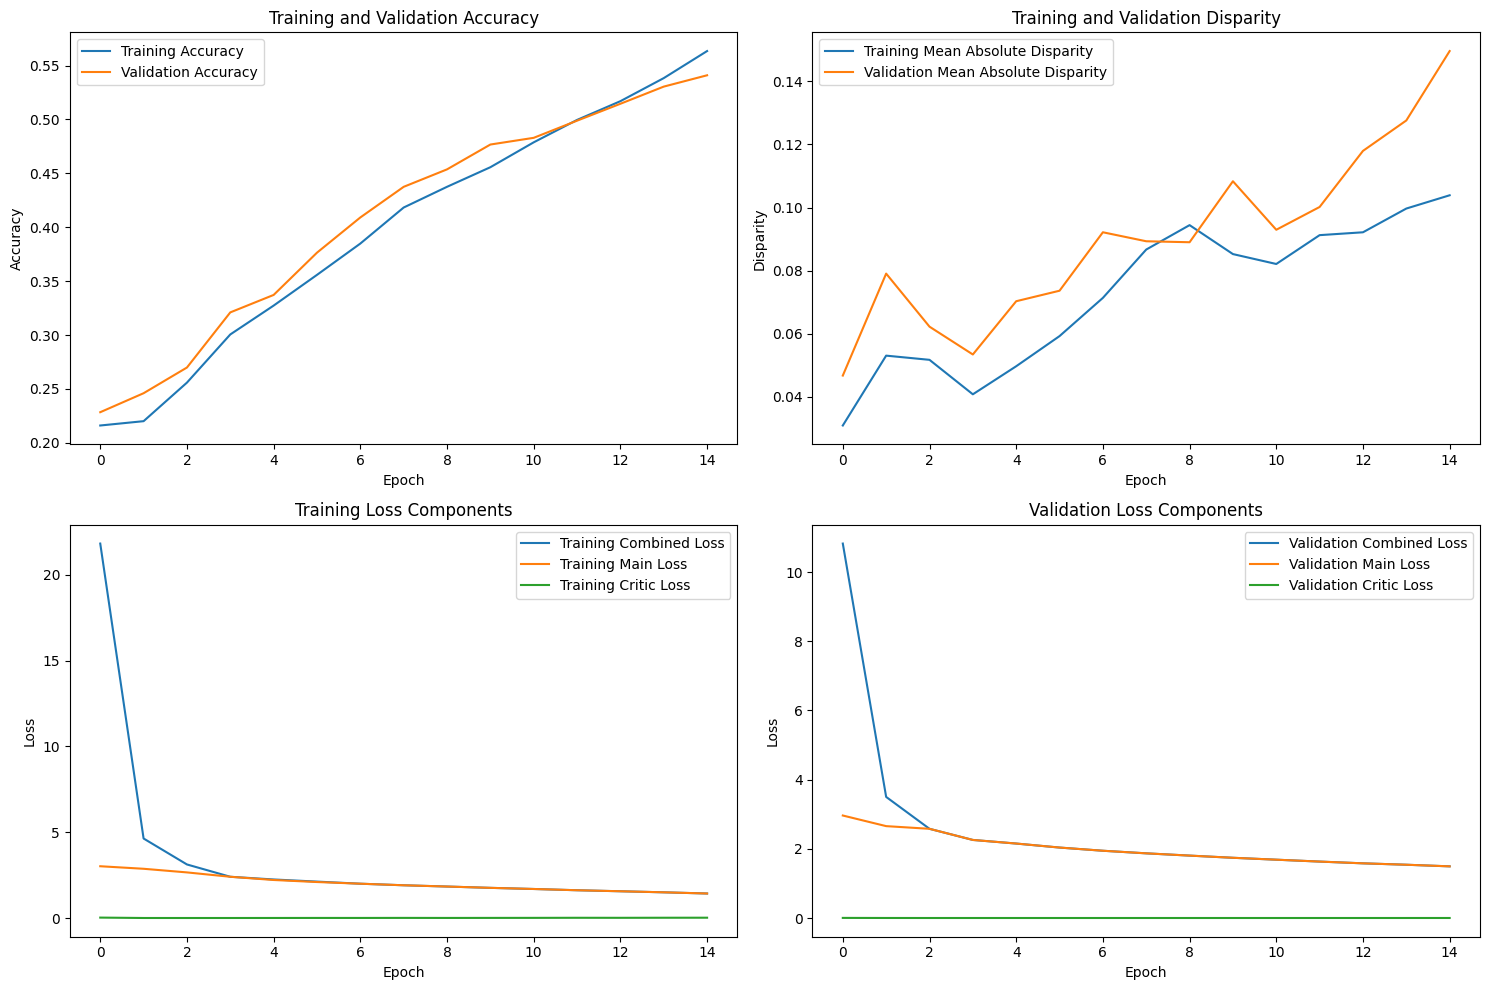

Epoch 16/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.34it/s]



Lambda 100 - Epoch 16 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.580363, VALIDATION Accuracy: 0.5544
TRAINING Disparity: 0.114351, VALIDATION Disparity: 0.1405
TRAINING Combined Loss: 1.373500, VALIDATION Combined Loss: 1.4632
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.11258868286664159
Class Celebration: Val Disparity = -0.028663366336633633
Class Parade: Val Disparity = 0.04166666666666663
Class Waiter_Or_Waitress: Val Disparity = -0.2913325696830852
Class Individual_Sports: Val Disparity = -0.12835518102372045
Class Surgeons: Val Disparity = -0.02217294900221728
Class Spa: Val Disparity = -0.5208333333333334
Class Law_Enforcement: Val Disparity = 0.21197183098591538
Class Business: Val Disparity = -0.06888108165655271
Class Dresses: Val Disparity = -0.39121756487025966
Class Water_Activities: Val Disparity = 0.010432190760059634
Class Picnic: Val Disparity = 0.06535947712418305
Class Rescue: Val Dis

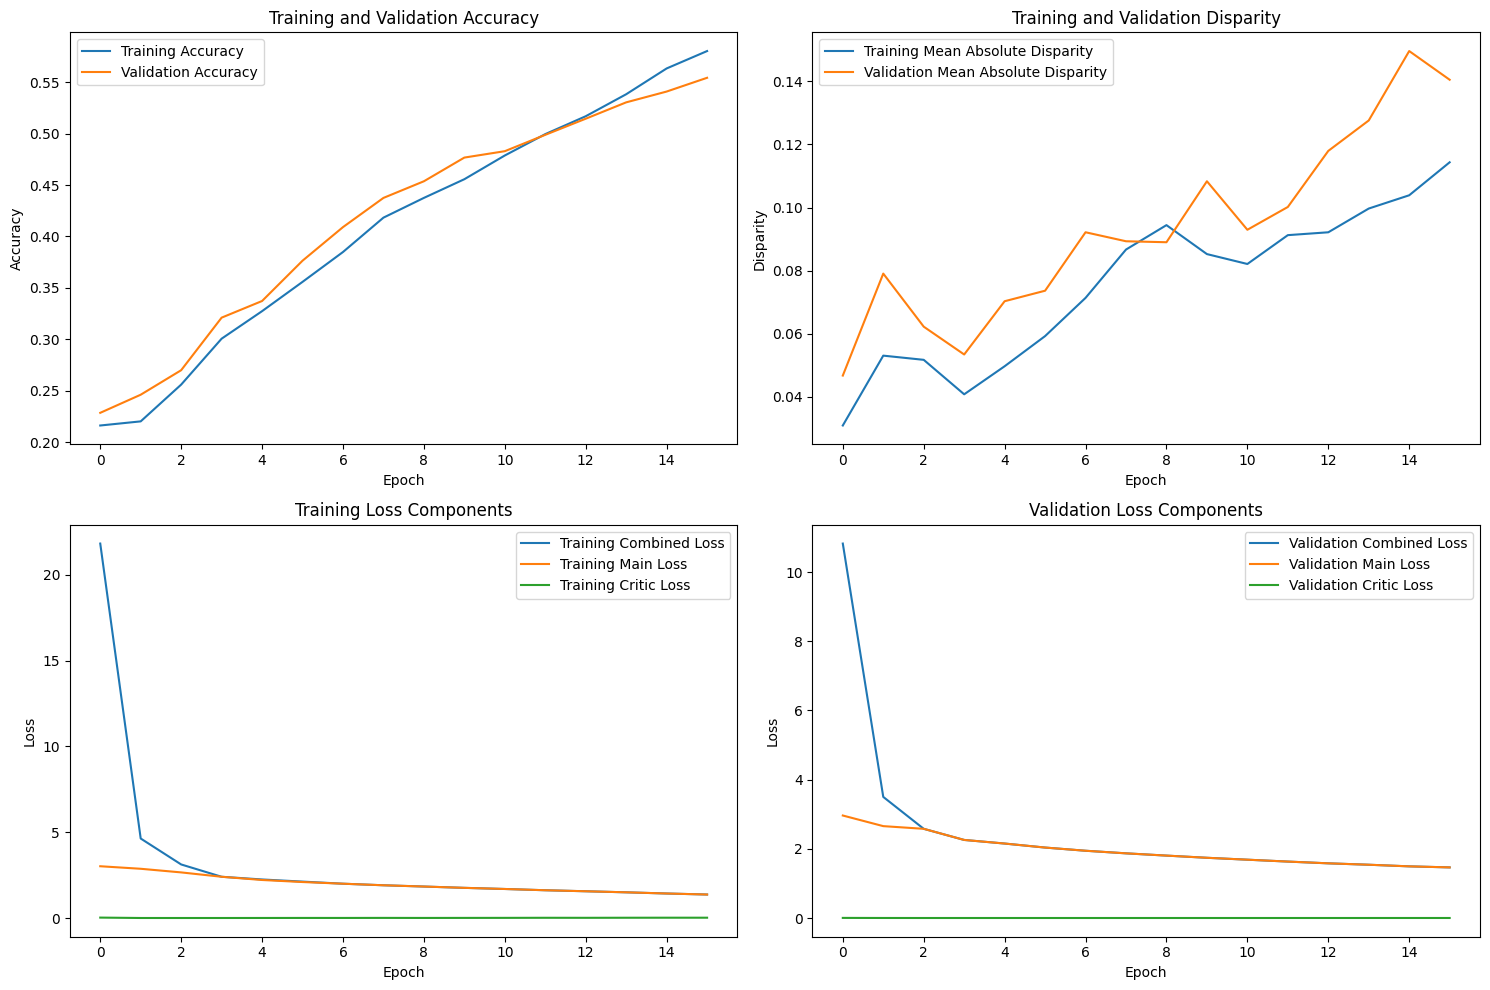

Epoch 17/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.24it/s]



Lambda 100 - Epoch 17 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.596605, VALIDATION Accuracy: 0.5654
TRAINING Disparity: 0.107753, VALIDATION Disparity: 0.1435
TRAINING Combined Loss: 1.316882, VALIDATION Combined Loss: 1.4240
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.09802241491585828
Class Celebration: Val Disparity = -0.03376237623762379
Class Parade: Val Disparity = 0.030303030303030165
Class Waiter_Or_Waitress: Val Disparity = -0.2153493699885453
Class Individual_Sports: Val Disparity = -0.153480024968789
Class Surgeons: Val Disparity = -0.05838876570583884
Class Spa: Val Disparity = -0.5208333333333334
Class Law_Enforcement: Val Disparity = 0.16971830985915487
Class Business: Val Disparity = -0.08953475992760568
Class Dresses: Val Disparity = -0.6766467065868264
Class Water_Activities: Val Disparity = 0.02001277411113478
Class Picnic: Val Disparity = -0.04575163398692811
Class Rescue: Val Dispar

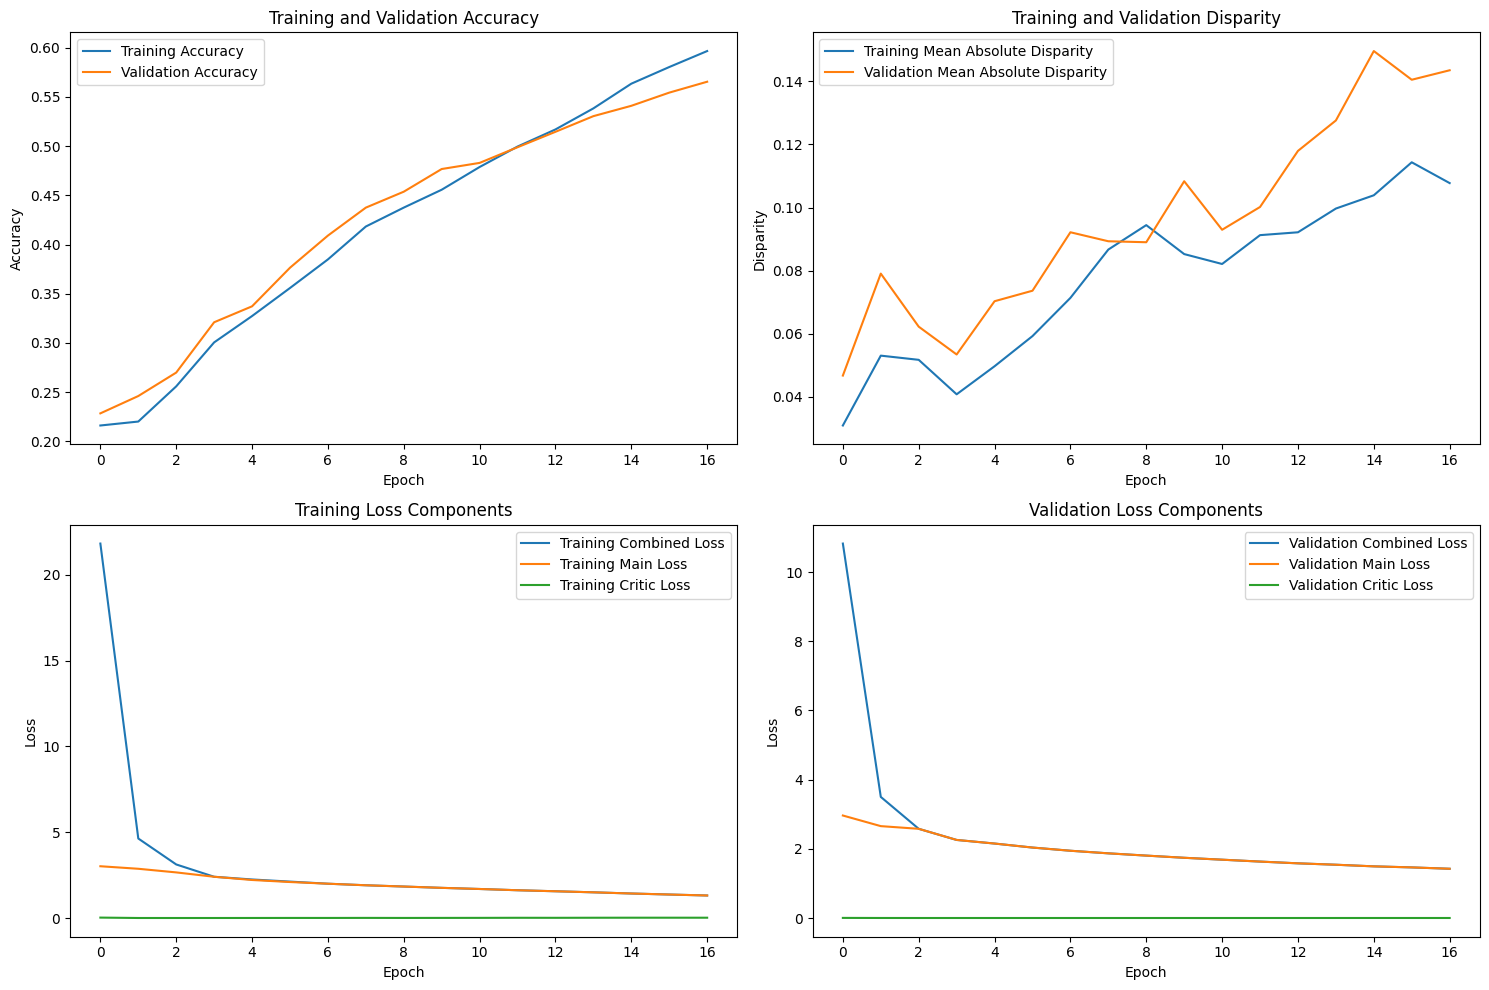

Epoch 18/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.24it/s]



Lambda 100 - Epoch 18 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.619194, VALIDATION Accuracy: 0.5723
TRAINING Disparity: 0.132030, VALIDATION Disparity: 0.1570
TRAINING Combined Loss: 1.243537, VALIDATION Combined Loss: 1.3929
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.10251225280186438
Class Celebration: Val Disparity = 0.020643564356435717
Class Parade: Val Disparity = 0.0359848484848484
Class Waiter_Or_Waitress: Val Disparity = -0.23787705231004191
Class Individual_Sports: Val Disparity = -0.14306335830212247
Class Surgeons: Val Disparity = -0.05838876570583884
Class Spa: Val Disparity = -0.5416666666666666
Class Law_Enforcement: Val Disparity = 0.17863849765258216
Class Business: Val Disparity = -0.07963376982859582
Class Dresses: Val Disparity = -0.7305389221556887
Class Water_Activities: Val Disparity = 0.04460293804556115
Class Picnic: Val Disparity = -0.10457516339869277
Class Rescue: Val Dispa

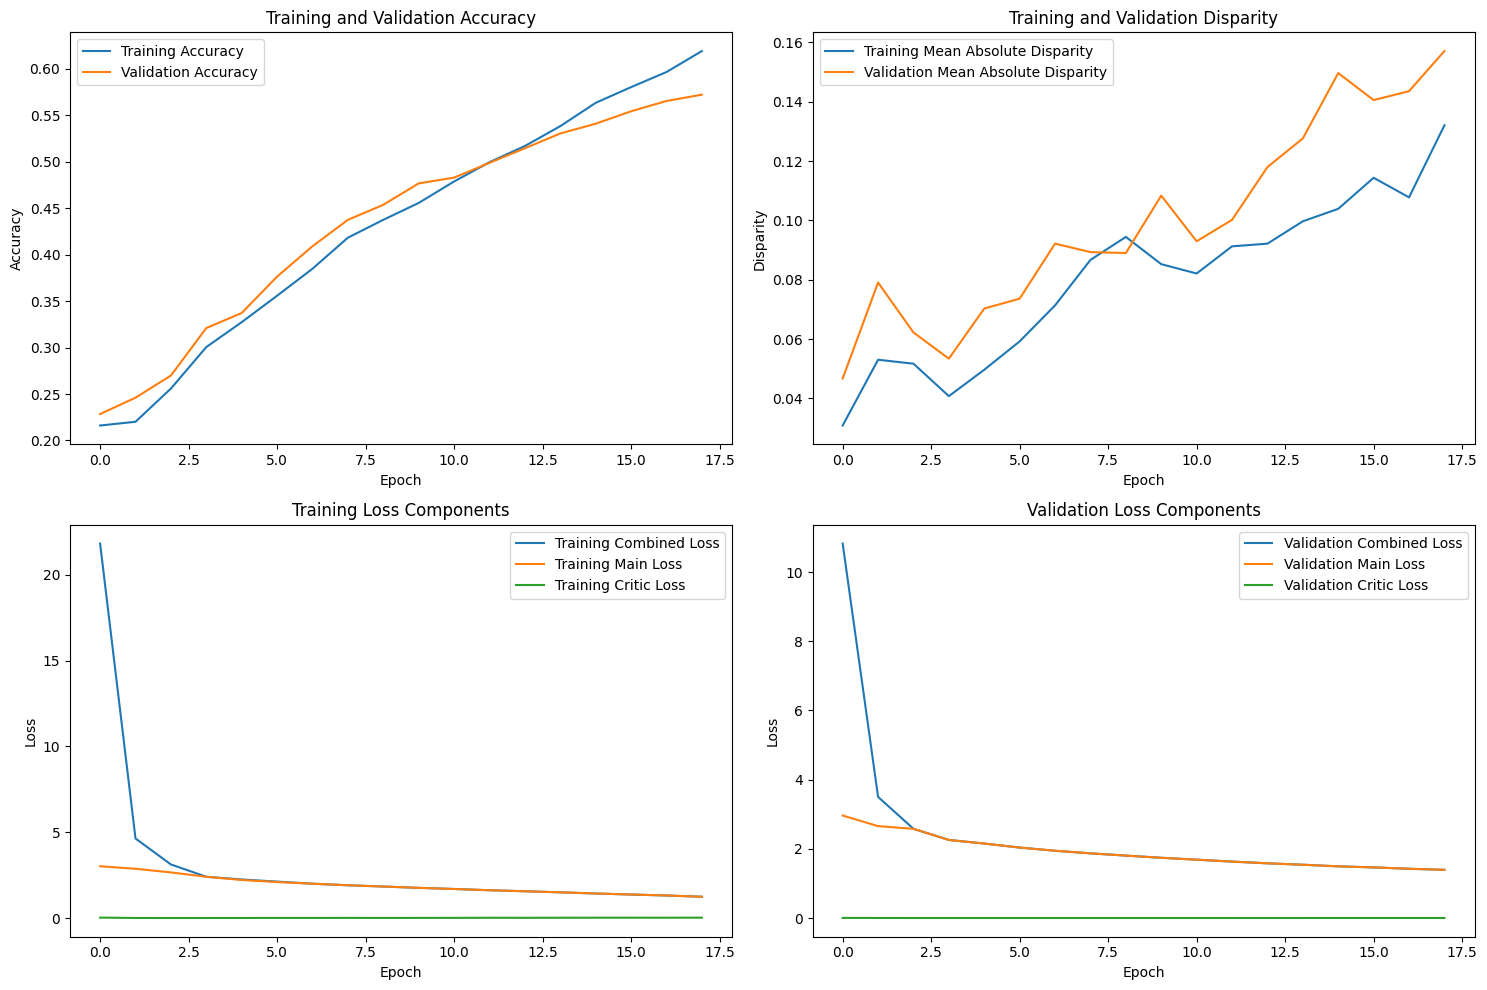

Epoch 19/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:17<00:00,  3.23it/s]



Lambda 100 - Epoch 19 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.638542, VALIDATION Accuracy: 0.5776
TRAINING Disparity: 0.136575, VALIDATION Disparity: 0.1371
TRAINING Combined Loss: 1.181242, VALIDATION Combined Loss: 1.3772
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.09064217248746154
Class Celebration: Val Disparity = -0.038861386138613785
Class Parade: Val Disparity = 0.045454545454545414
Class Waiter_Or_Waitress: Val Disparity = -0.0878197785414282
Class Individual_Sports: Val Disparity = -0.16736891385767794
Class Surgeons: Val Disparity = -0.07021433850702147
Class Spa: Val Disparity = -0.6458333333333333
Class Law_Enforcement: Val Disparity = 0.1575117370892019
Class Business: Val Disparity = -0.05983178963057595
Class Dresses: Val Disparity = -0.5459081836327346
Class Water_Activities: Val Disparity = -0.02373855652544188
Class Picnic: Val Disparity = -0.013071895424836555
Class Rescue: Val Di

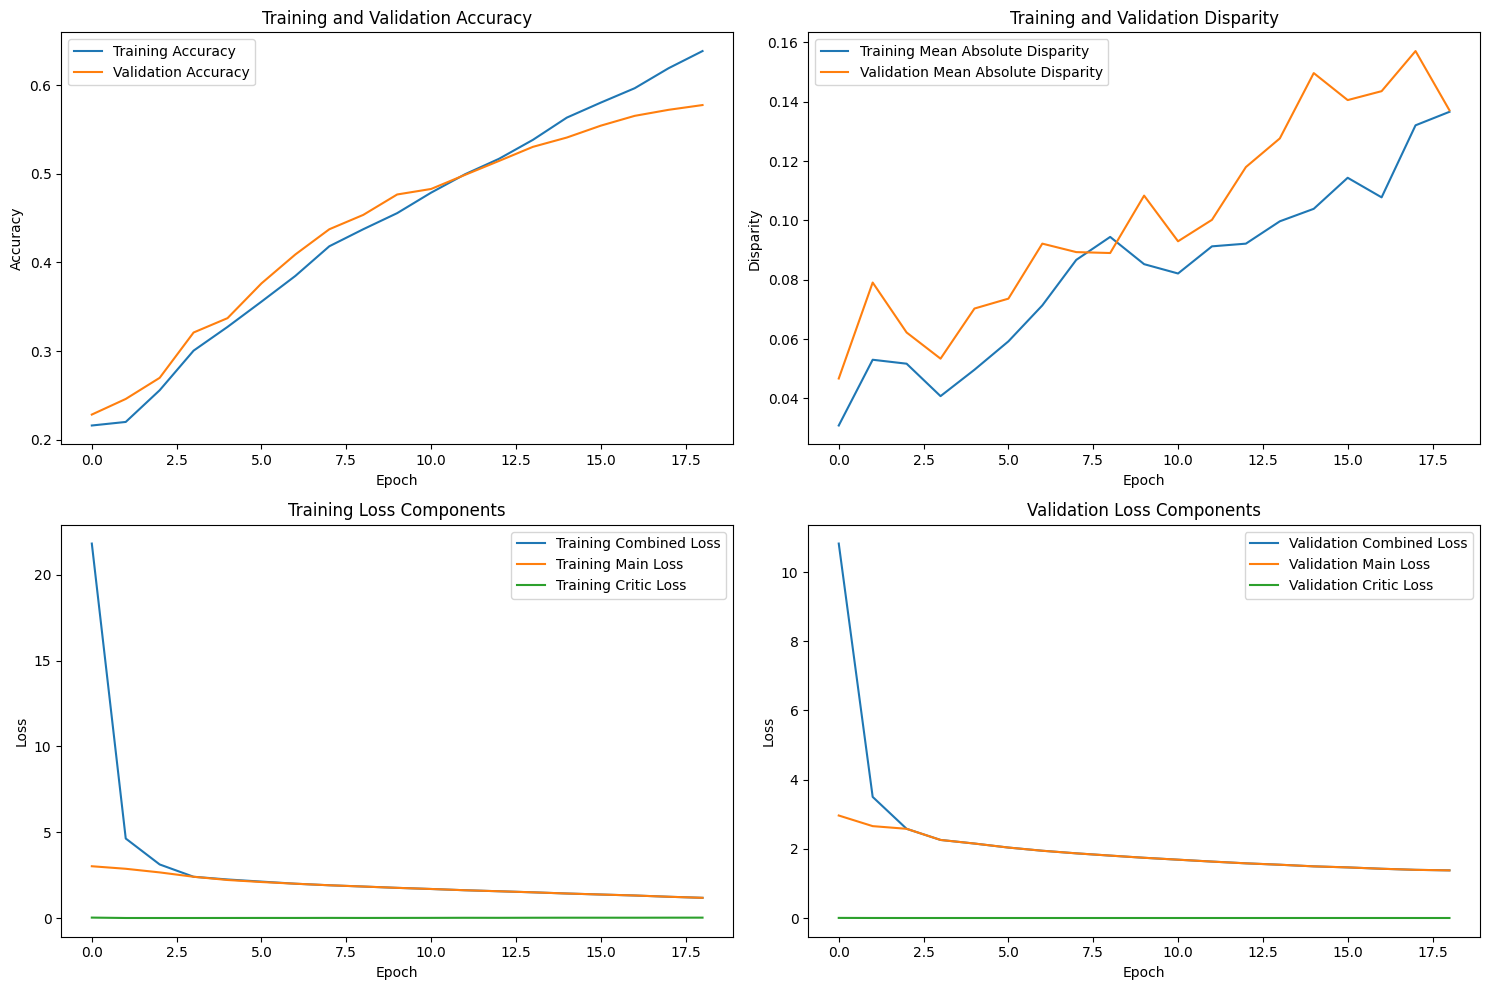

Epoch 20/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.27it/s]



Lambda 100 - Epoch 20 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.659433, VALIDATION Accuracy: 0.5850
TRAINING Disparity: 0.105204, VALIDATION Disparity: 0.1465
TRAINING Combined Loss: 1.112931, VALIDATION Combined Loss: 1.3535
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.06230935325770304
Class Celebration: Val Disparity = -0.009059405940594012
Class Parade: Val Disparity = 0.035037878787878673
Class Waiter_Or_Waitress: Val Disparity = -0.11454753722794975
Class Individual_Sports: Val Disparity = -0.16553526841448196
Class Surgeons: Val Disparity = -0.03991130820399108
Class Spa: Val Disparity = -0.6041666666666666
Class Law_Enforcement: Val Disparity = 0.14272300469483568
Class Business: Val Disparity = -0.02022782923453631
Class Dresses: Val Disparity = -0.688622754491018
Class Water_Activities: Val Disparity = -0.018948264849904195
Class Picnic: Val Disparity = -0.21568627450980388
Class Rescue: Val D

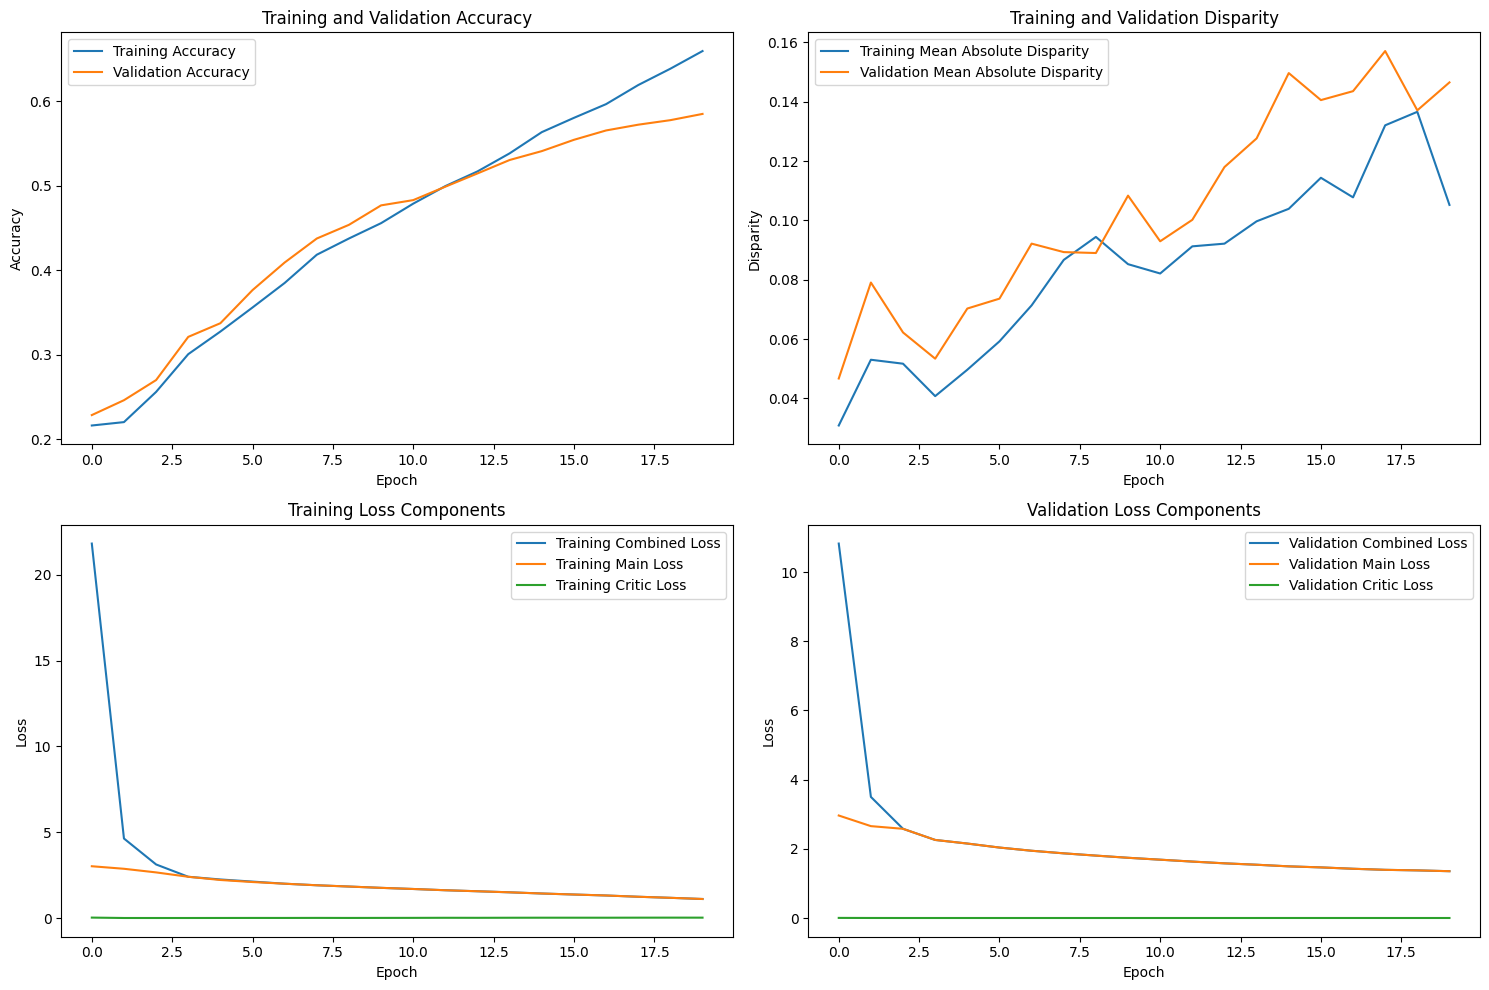

Epoch 21/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.29it/s]



Lambda 100 - Epoch 21 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.679167, VALIDATION Accuracy: 0.5833
TRAINING Disparity: 0.124868, VALIDATION Disparity: 0.1139
TRAINING Combined Loss: 1.041052, VALIDATION Combined Loss: 1.3436
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.0653025785150404
Class Celebration: Val Disparity = 0.020940594059405904
Class Parade: Val Disparity = 0.08333333333333326
Class Waiter_Or_Waitress: Val Disparity = -0.04467353951890052
Class Individual_Sports: Val Disparity = -0.16982677902621734
Class Surgeons: Val Disparity = -0.07021433850702141
Class Spa: Val Disparity = -0.14583333333333326
Class Law_Enforcement: Val Disparity = 0.1708920187793429
Class Business: Val Disparity = -0.028425423187480037
Class Dresses: Val Disparity = -0.688622754491018
Class Water_Activities: Val Disparity = 0.013199914839259086
Class Picnic: Val Disparity = 0.0065359477124183885
Class Rescue: Val Dis

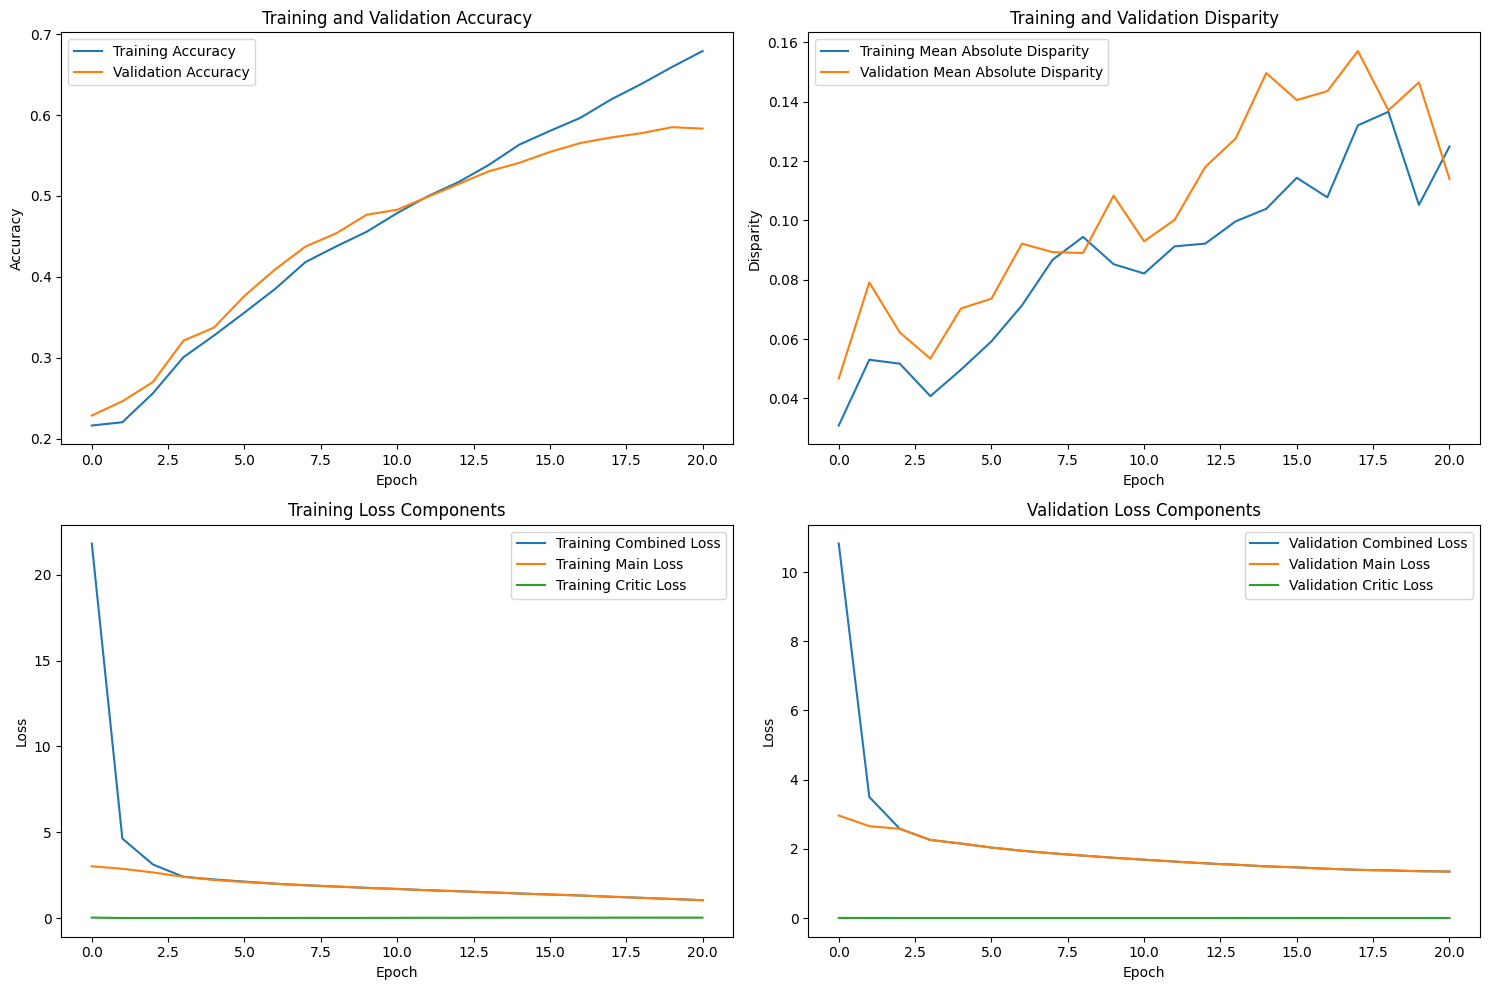

Epoch 22/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.26it/s]



Lambda 100 - Epoch 22 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.696624, VALIDATION Accuracy: 0.5887
TRAINING Disparity: 0.120469, VALIDATION Disparity: 0.1428
TRAINING Combined Loss: 0.979564, VALIDATION Combined Loss: 1.3355
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.06026436348265196
Class Celebration: Val Disparity = -0.024158415841584235
Class Parade: Val Disparity = 0.09659090909090906
Class Waiter_Or_Waitress: Val Disparity = -0.06109201985490642
Class Individual_Sports: Val Disparity = -0.184730024968789
Class Surgeons: Val Disparity = -0.07021433850702147
Class Spa: Val Disparity = -0.6458333333333333
Class Law_Enforcement: Val Disparity = 0.10938967136150246
Class Business: Val Disparity = -0.037474715213456855
Class Dresses: Val Disparity = -0.7185628742514969
Class Water_Activities: Val Disparity = -0.010751543538428887
Class Picnic: Val Disparity = -0.0326797385620915
Class Rescue: Val Dis

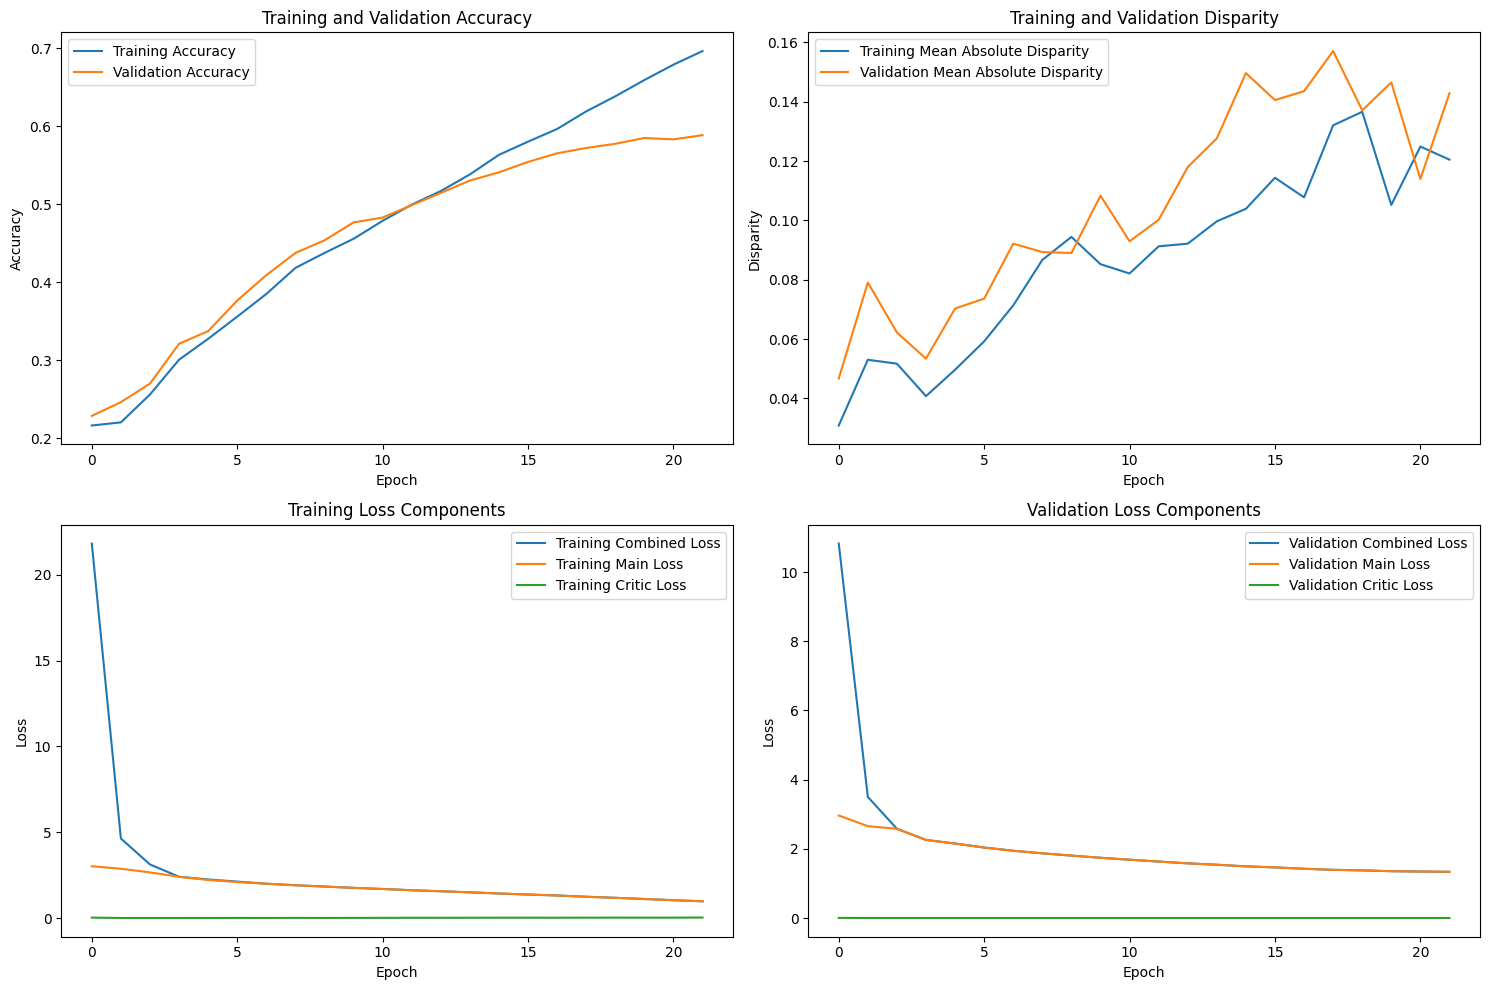

Epoch 23/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.32it/s]



Lambda 100 - Epoch 23 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.721836, VALIDATION Accuracy: 0.6024
TRAINING Disparity: 0.113473, VALIDATION Disparity: 0.1445
TRAINING Combined Loss: 0.899319, VALIDATION Combined Loss: 1.3288
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.044052964092721525
Class Celebration: Val Disparity = -0.054059405940593996
Class Parade: Val Disparity = 0.08806818181818177
Class Waiter_Or_Waitress: Val Disparity = -0.15578465063001157
Class Individual_Sports: Val Disparity = -0.11895287141073663
Class Surgeons: Val Disparity = -0.05173688100517365
Class Spa: Val Disparity = -0.6041666666666665
Class Law_Enforcement: Val Disparity = 0.0971830985915495
Class Business: Val Disparity = -0.0210795273075694
Class Dresses: Val Disparity = -0.688622754491018
Class Water_Activities: Val Disparity = 0.007025761124121788
Class Picnic: Val Disparity = -0.1633986928104575
Class Rescue: Val Dispa

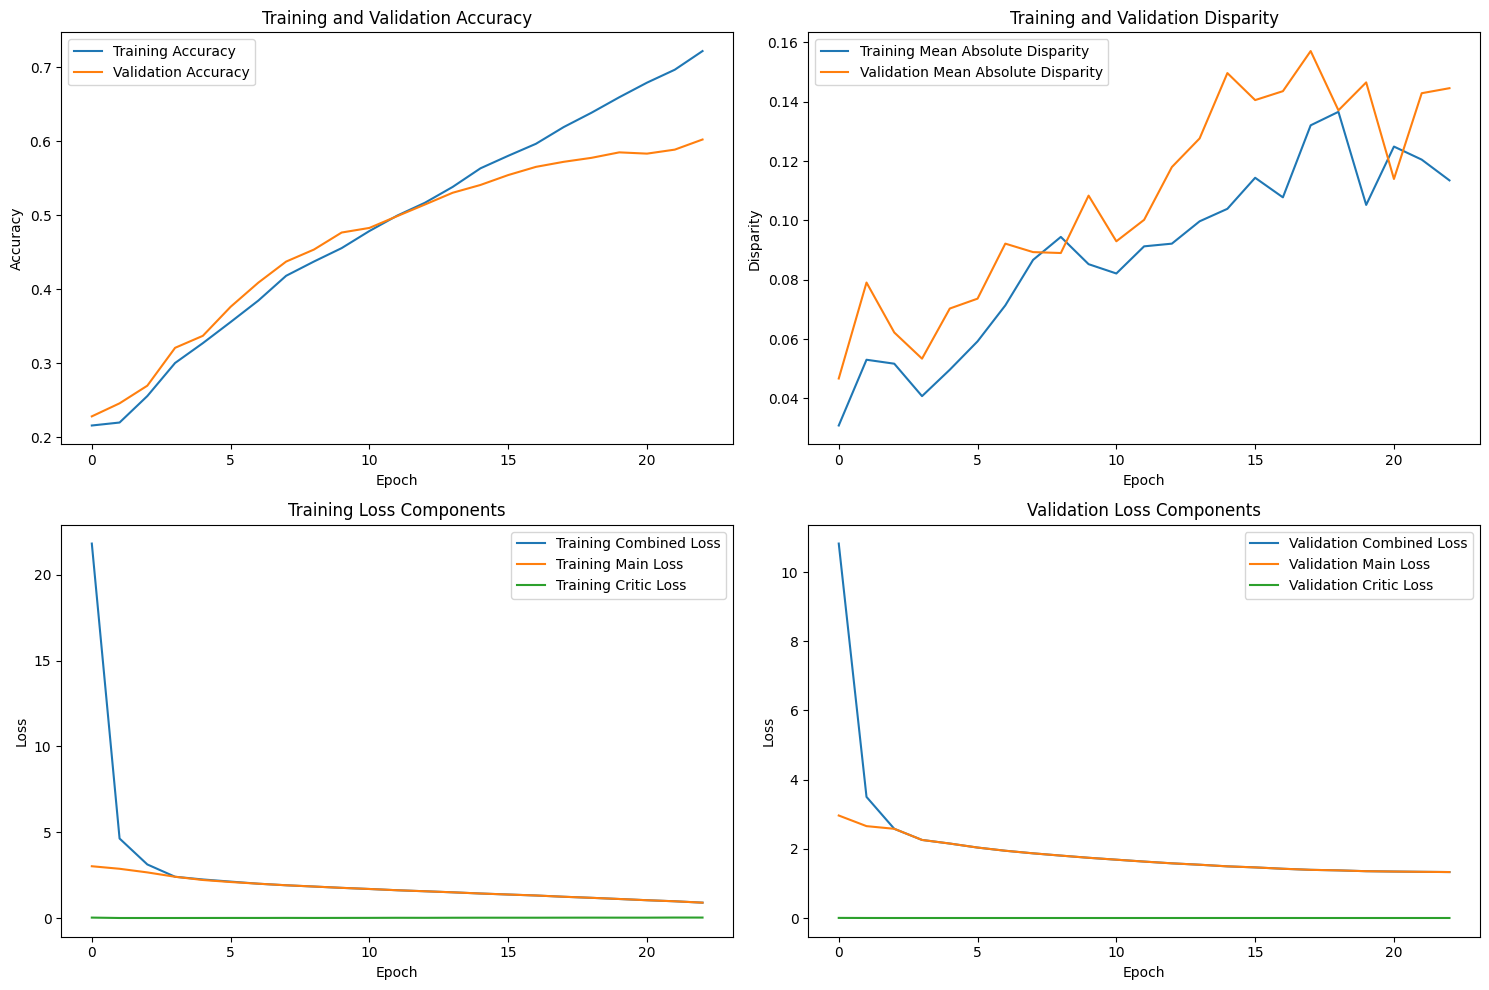

Epoch 24/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.24it/s]



Lambda 100 - Epoch 24 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.744213, VALIDATION Accuracy: 0.6072
TRAINING Disparity: 0.110407, VALIDATION Disparity: 0.1445
TRAINING Combined Loss: 0.834508, VALIDATION Combined Loss: 1.3317
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.044052964092721525
Class Celebration: Val Disparity = -0.054059405940593996
Class Parade: Val Disparity = 0.08806818181818177
Class Waiter_Or_Waitress: Val Disparity = -0.15578465063001157
Class Individual_Sports: Val Disparity = -0.11895287141073663
Class Surgeons: Val Disparity = -0.05173688100517365
Class Spa: Val Disparity = -0.6041666666666665
Class Law_Enforcement: Val Disparity = 0.0971830985915495
Class Business: Val Disparity = -0.0210795273075694
Class Dresses: Val Disparity = -0.688622754491018
Class Water_Activities: Val Disparity = 0.007025761124121788
Class Picnic: Val Disparity = -0.1633986928104575
Class Rescue: Val Dispa

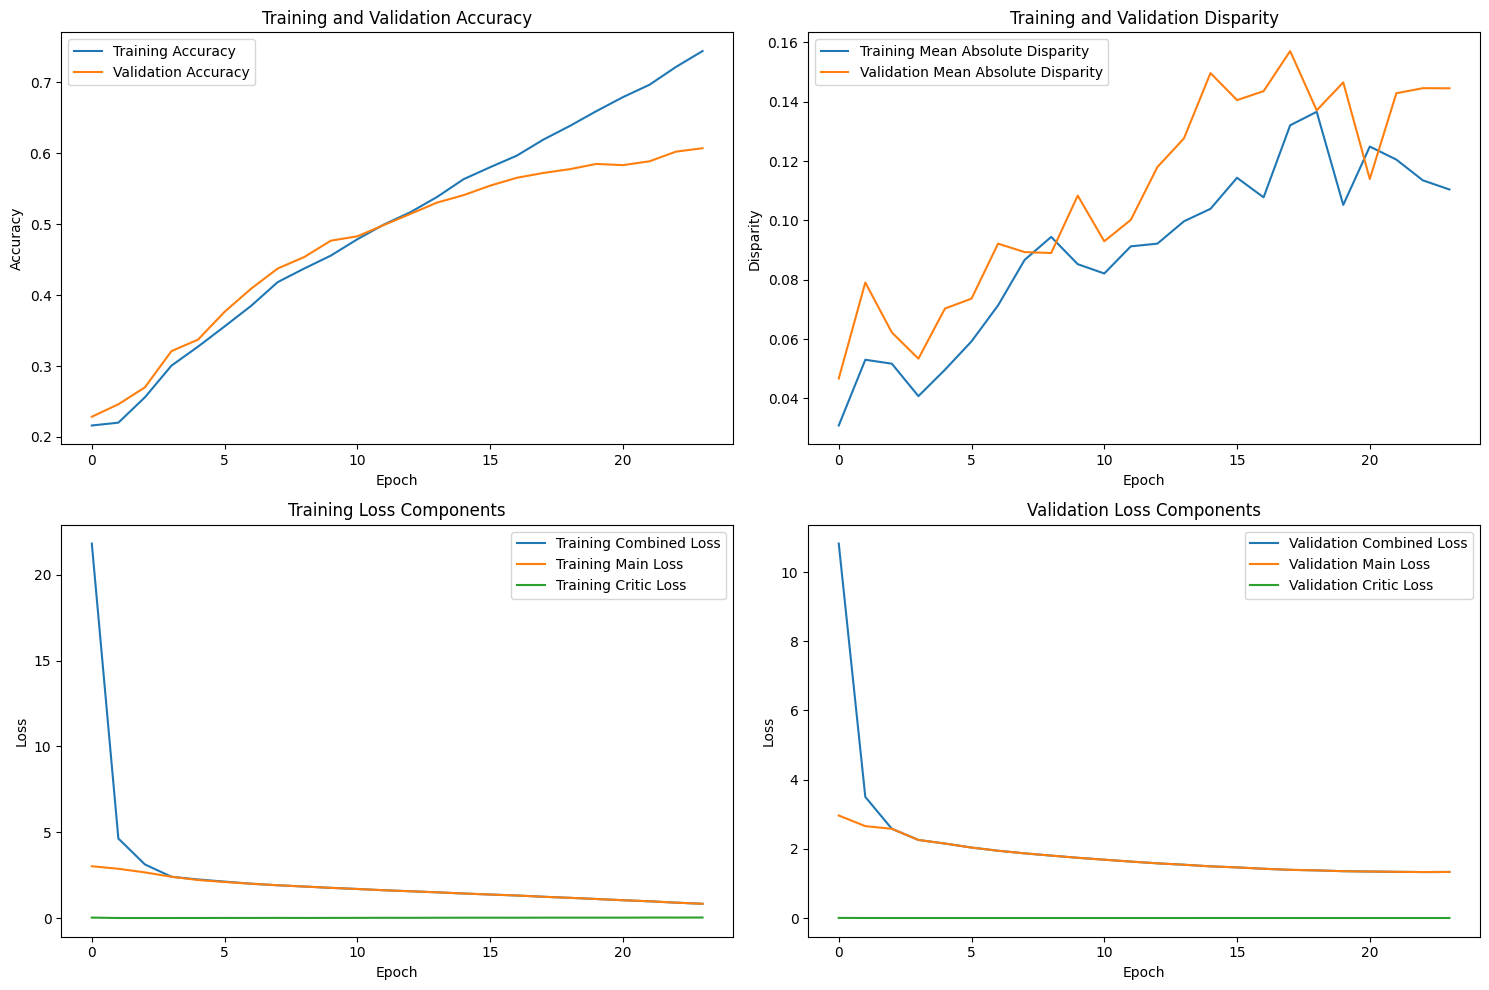

Epoch 25/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.27it/s]



Lambda 100 - Epoch 25 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.768441, VALIDATION Accuracy: 0.5997
TRAINING Disparity: 0.109962, VALIDATION Disparity: 0.1182
TRAINING Combined Loss: 0.747355, VALIDATION Combined Loss: 1.3603
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.044052964092721525
Class Celebration: Val Disparity = -0.054059405940593996
Class Parade: Val Disparity = 0.08806818181818177
Class Waiter_Or_Waitress: Val Disparity = -0.15578465063001157
Class Individual_Sports: Val Disparity = -0.11895287141073663
Class Surgeons: Val Disparity = -0.05173688100517365
Class Spa: Val Disparity = -0.6041666666666665
Class Law_Enforcement: Val Disparity = 0.0971830985915495
Class Business: Val Disparity = -0.0210795273075694
Class Dresses: Val Disparity = -0.688622754491018
Class Water_Activities: Val Disparity = 0.007025761124121788
Class Picnic: Val Disparity = -0.1633986928104575
Class Rescue: Val Dispa

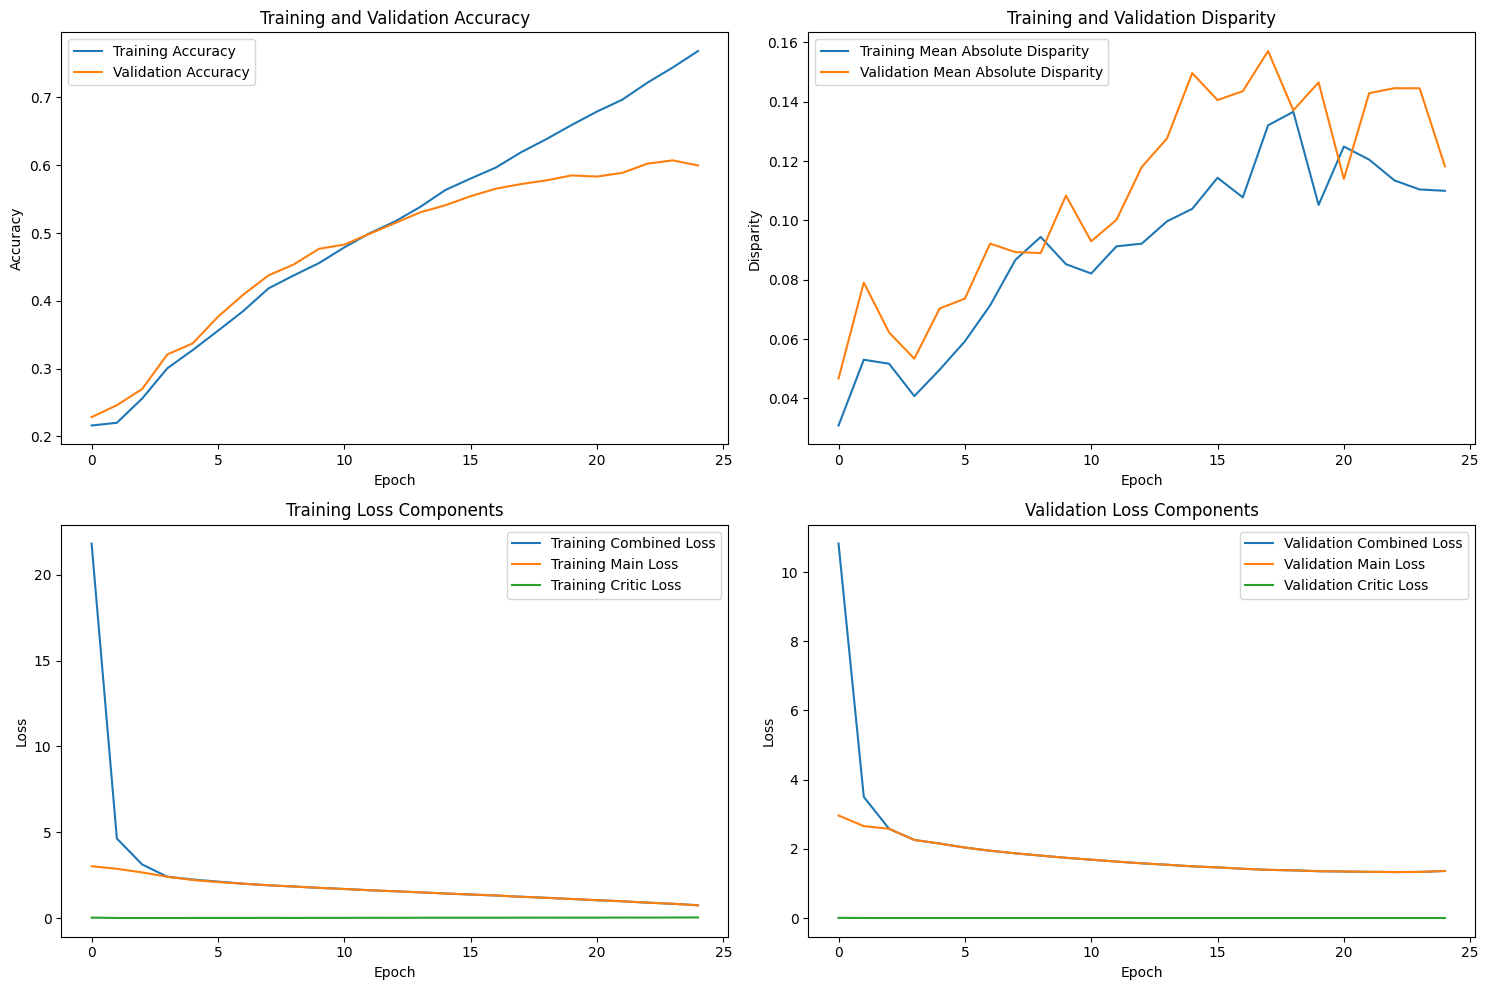

Epoch 26/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.32it/s]



Lambda 100 - Epoch 26 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.800405, VALIDATION Accuracy: 0.6074
TRAINING Disparity: 0.103660, VALIDATION Disparity: 0.1149
TRAINING Combined Loss: 0.665022, VALIDATION Combined Loss: 1.3862
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.044052964092721525
Class Celebration: Val Disparity = -0.054059405940593996
Class Parade: Val Disparity = 0.08806818181818177
Class Waiter_Or_Waitress: Val Disparity = -0.15578465063001157
Class Individual_Sports: Val Disparity = -0.11895287141073663
Class Surgeons: Val Disparity = -0.05173688100517365
Class Spa: Val Disparity = -0.6041666666666665
Class Law_Enforcement: Val Disparity = 0.0971830985915495
Class Business: Val Disparity = -0.0210795273075694
Class Dresses: Val Disparity = -0.688622754491018
Class Water_Activities: Val Disparity = 0.007025761124121788
Class Picnic: Val Disparity = -0.1633986928104575
Class Rescue: Val Dispa

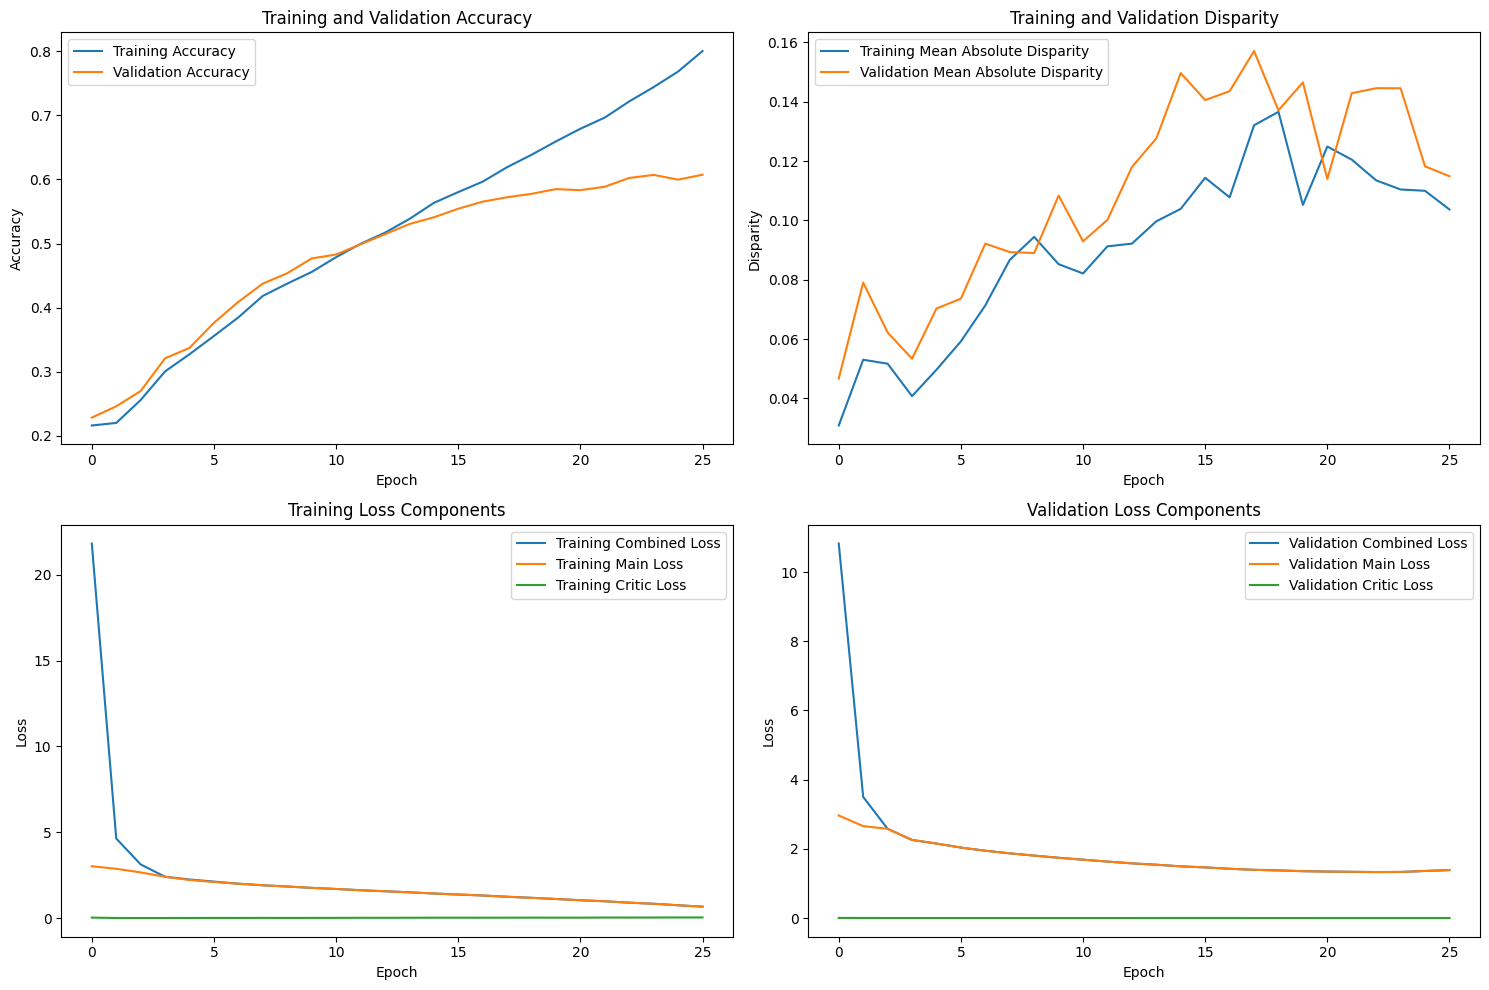

Epoch 27/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.28it/s]



Lambda 100 - Epoch 27 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.825019, VALIDATION Accuracy: 0.6032
TRAINING Disparity: 0.082053, VALIDATION Disparity: 0.1204
TRAINING Combined Loss: 0.586475, VALIDATION Combined Loss: 1.4189
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.044052964092721525
Class Celebration: Val Disparity = -0.054059405940593996
Class Parade: Val Disparity = 0.08806818181818177
Class Waiter_Or_Waitress: Val Disparity = -0.15578465063001157
Class Individual_Sports: Val Disparity = -0.11895287141073663
Class Surgeons: Val Disparity = -0.05173688100517365
Class Spa: Val Disparity = -0.6041666666666665
Class Law_Enforcement: Val Disparity = 0.0971830985915495
Class Business: Val Disparity = -0.0210795273075694
Class Dresses: Val Disparity = -0.688622754491018
Class Water_Activities: Val Disparity = 0.007025761124121788
Class Picnic: Val Disparity = -0.1633986928104575
Class Rescue: Val Dispa

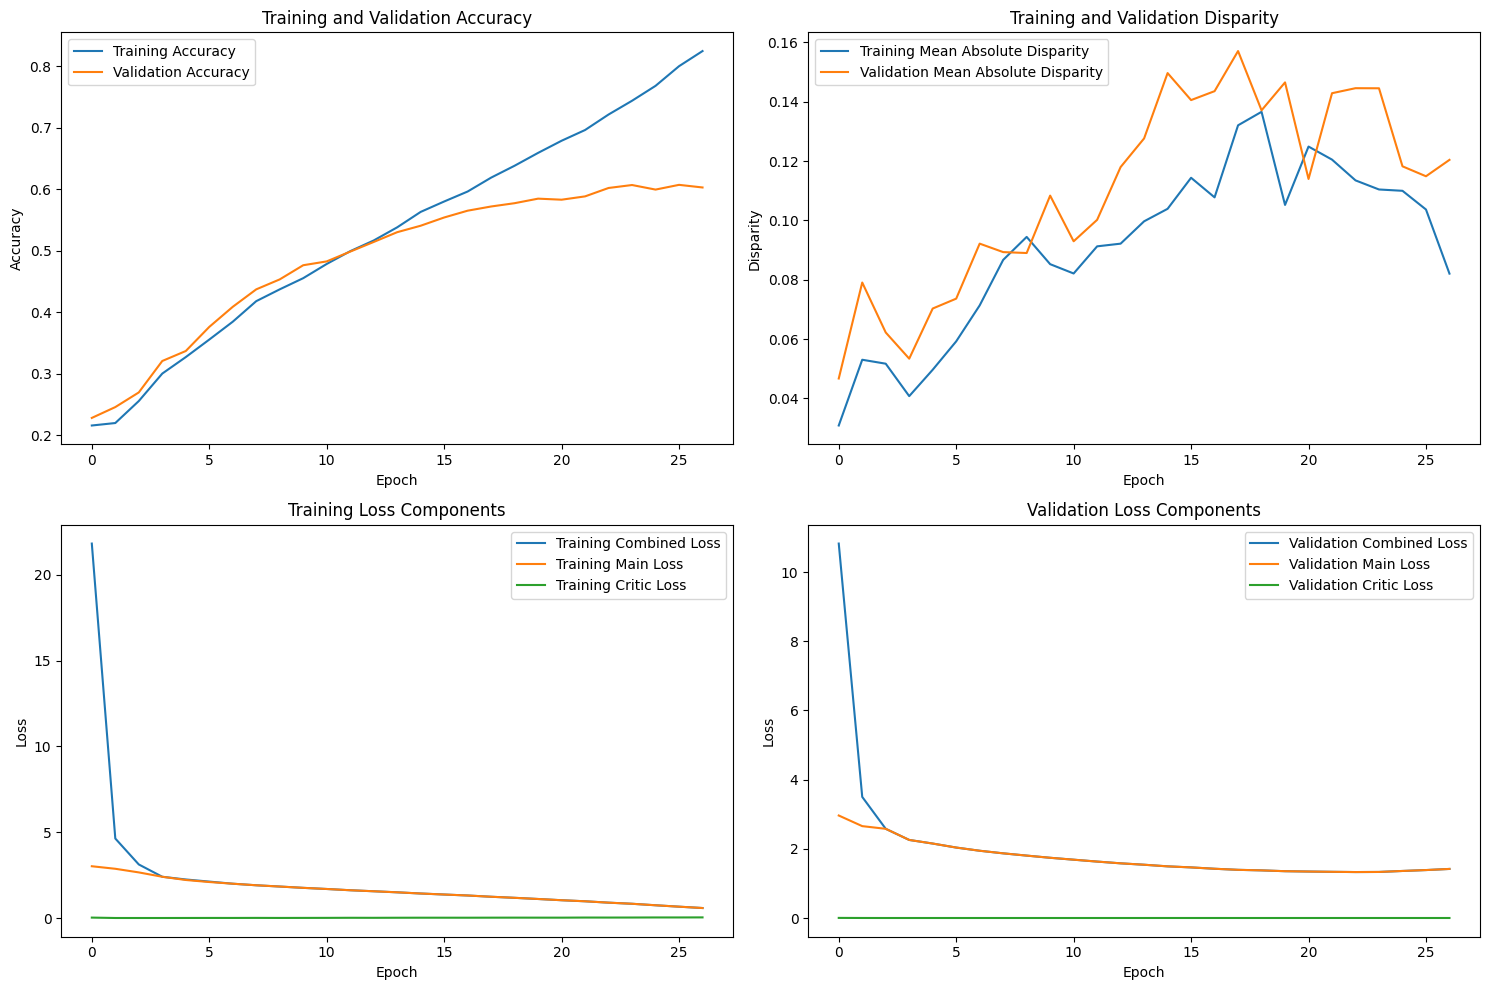

Epoch 28/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.26it/s]



Lambda 100 - Epoch 28 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.853800, VALIDATION Accuracy: 0.6038
TRAINING Disparity: 0.092130, VALIDATION Disparity: 0.1258
TRAINING Combined Loss: 0.497331, VALIDATION Combined Loss: 1.4673
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.044052964092721525
Class Celebration: Val Disparity = -0.054059405940593996
Class Parade: Val Disparity = 0.08806818181818177
Class Waiter_Or_Waitress: Val Disparity = -0.15578465063001157
Class Individual_Sports: Val Disparity = -0.11895287141073663
Class Surgeons: Val Disparity = -0.05173688100517365
Class Spa: Val Disparity = -0.6041666666666665
Class Law_Enforcement: Val Disparity = 0.0971830985915495
Class Business: Val Disparity = -0.0210795273075694
Class Dresses: Val Disparity = -0.688622754491018
Class Water_Activities: Val Disparity = 0.007025761124121788
Class Picnic: Val Disparity = -0.1633986928104575
Class Rescue: Val Dispa

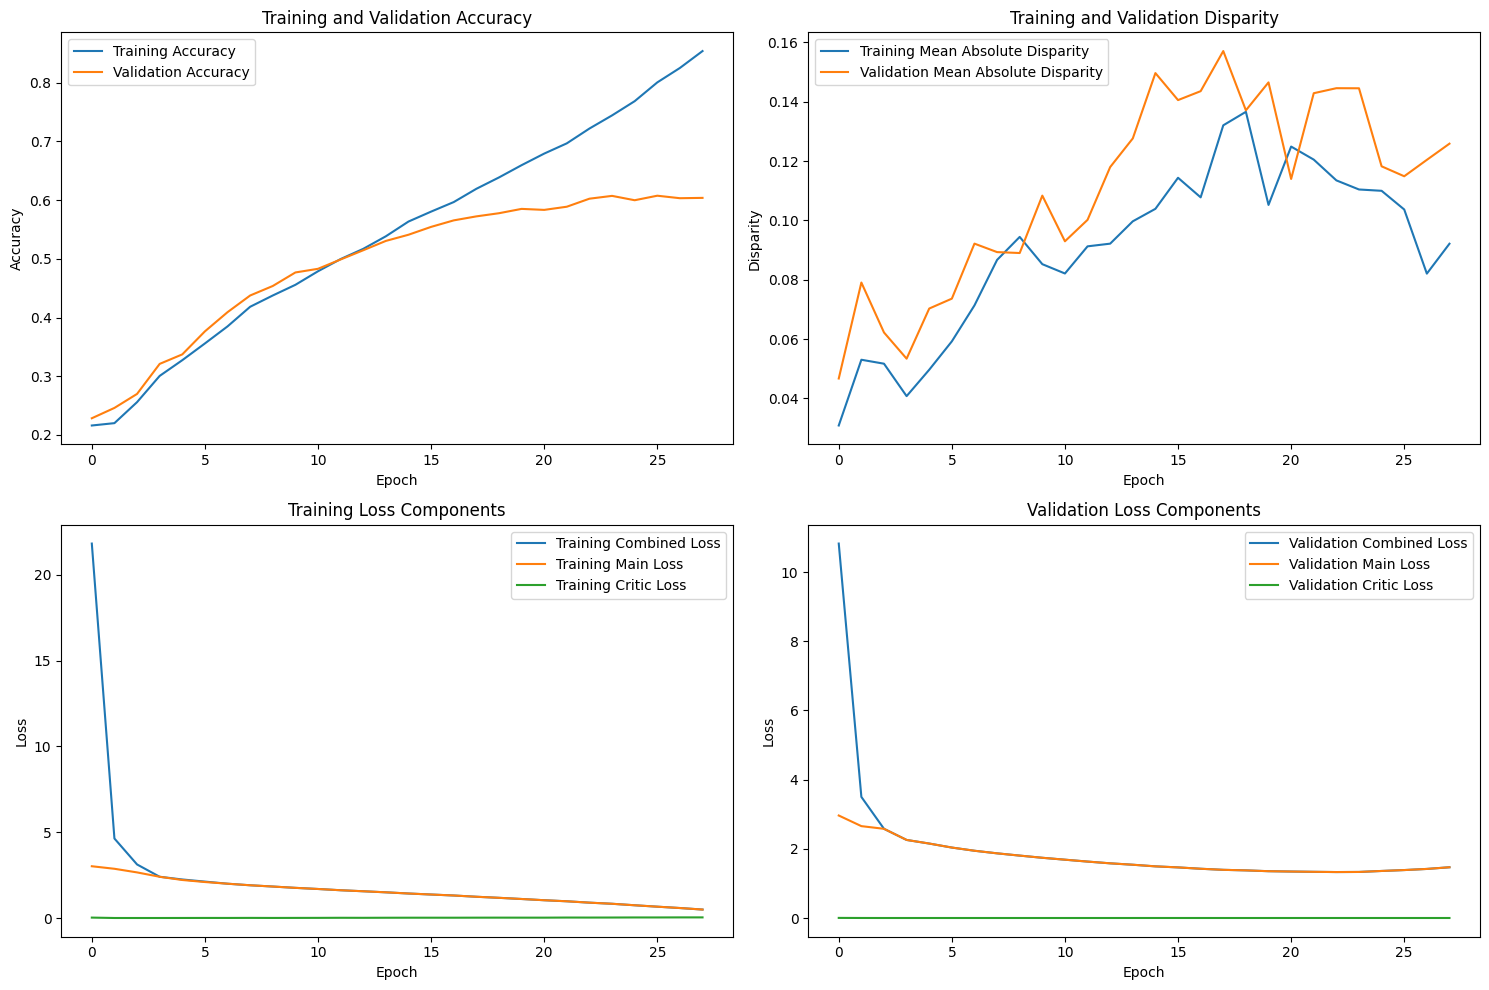

Epoch 29/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.25it/s]


Early stopping triggered at epoch 29
Finished Training with lambda value of 100. Best (stopping) epoch number: 23


Epoch 1/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.25it/s]



Lambda 0 - Epoch 1 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.897782, VALIDATION Accuracy: 0.6023
TRAINING Disparity: 0.082958, VALIDATION Disparity: 0.1131
TRAINING Combined Loss: 0.352191, VALIDATION Combined Loss: 1.5846
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.06774742662599542
Class Celebration: Val Disparity = -0.009455445544554464
Class Parade: Val Disparity = 0.1297348484848483
Class Waiter_Or_Waitress: Val Disparity = -0.04467353951890041
Class Individual_Sports: Val Disparity = -0.10241104868913864
Class Surgeons: Val Disparity = -0.057649667405765104
Class Spa: Val Disparity = -0.04166666666666663
Class Law_Enforcement: Val Disparity = 0.008215962441314728
Class Business: Val Disparity = -0.0640902799957414
Class Dresses: Val Disparity = -0.6946107784431138
Class Water_Activities: Val Disparity = 0.0008516074089843784
Class Picnic: Val Disparity = -0.36601307189542487
Class Rescue: Val Dis

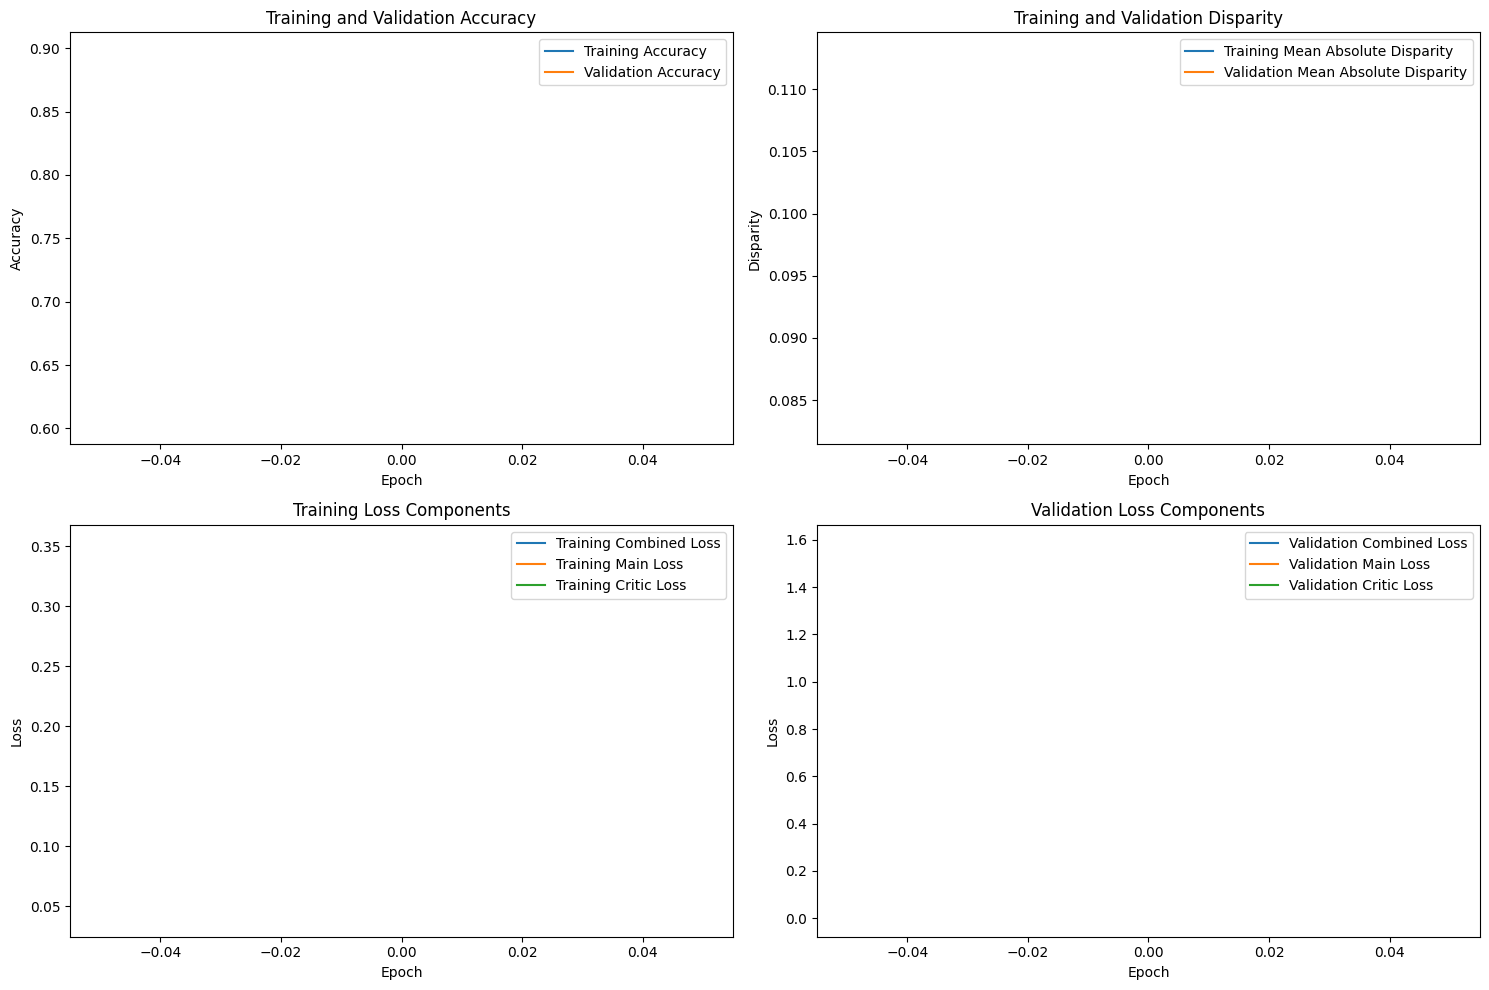

Epoch 2/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.26it/s]



Lambda 0 - Epoch 2 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.918846, VALIDATION Accuracy: 0.6035
TRAINING Disparity: 0.051480, VALIDATION Disparity: 0.1104
TRAINING Combined Loss: 0.286127, VALIDATION Combined Loss: 1.6311
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.06774742662599542
Class Celebration: Val Disparity = -0.009455445544554464
Class Parade: Val Disparity = 0.1297348484848483
Class Waiter_Or_Waitress: Val Disparity = -0.04467353951890041
Class Individual_Sports: Val Disparity = -0.10241104868913864
Class Surgeons: Val Disparity = -0.057649667405765104
Class Spa: Val Disparity = -0.04166666666666663
Class Law_Enforcement: Val Disparity = 0.008215962441314728
Class Business: Val Disparity = -0.0640902799957414
Class Dresses: Val Disparity = -0.6946107784431138
Class Water_Activities: Val Disparity = 0.0008516074089843784
Class Picnic: Val Disparity = -0.36601307189542487
Class Rescue: Val Dis

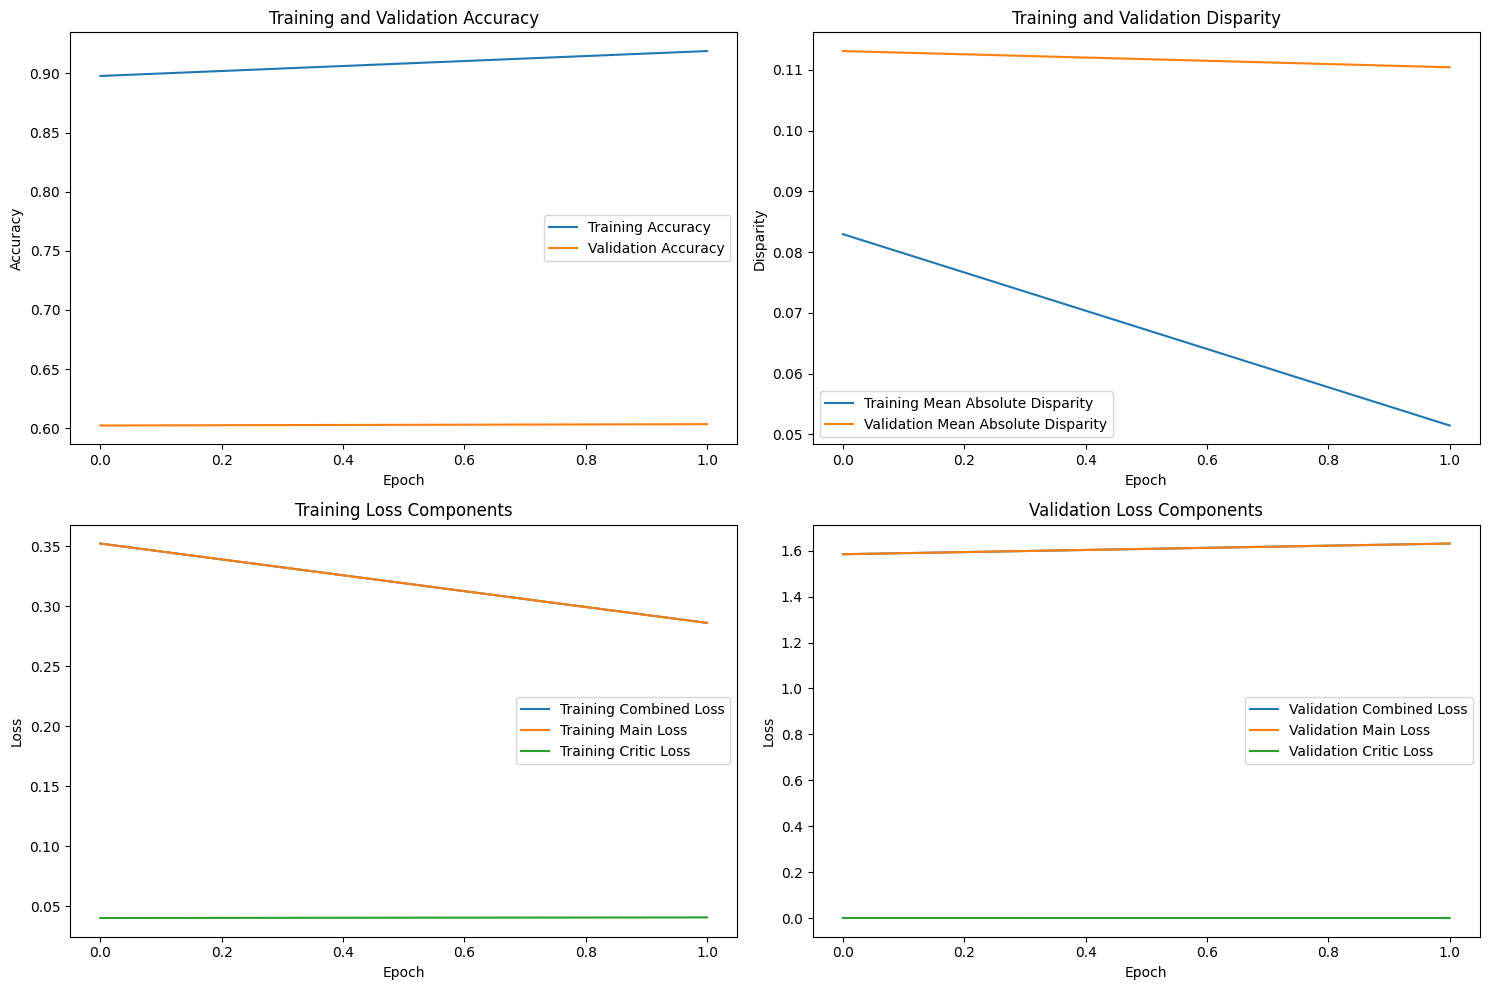

Epoch 3/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.25it/s]



Lambda 0 - Epoch 3 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.932292, VALIDATION Accuracy: 0.5986
TRAINING Disparity: 0.028790, VALIDATION Disparity: 0.1356
TRAINING Combined Loss: 0.241908, VALIDATION Combined Loss: 1.7302
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.06774742662599542
Class Celebration: Val Disparity = -0.009455445544554464
Class Parade: Val Disparity = 0.1297348484848483
Class Waiter_Or_Waitress: Val Disparity = -0.04467353951890041
Class Individual_Sports: Val Disparity = -0.10241104868913864
Class Surgeons: Val Disparity = -0.057649667405765104
Class Spa: Val Disparity = -0.04166666666666663
Class Law_Enforcement: Val Disparity = 0.008215962441314728
Class Business: Val Disparity = -0.0640902799957414
Class Dresses: Val Disparity = -0.6946107784431138
Class Water_Activities: Val Disparity = 0.0008516074089843784
Class Picnic: Val Disparity = -0.36601307189542487
Class Rescue: Val Dis

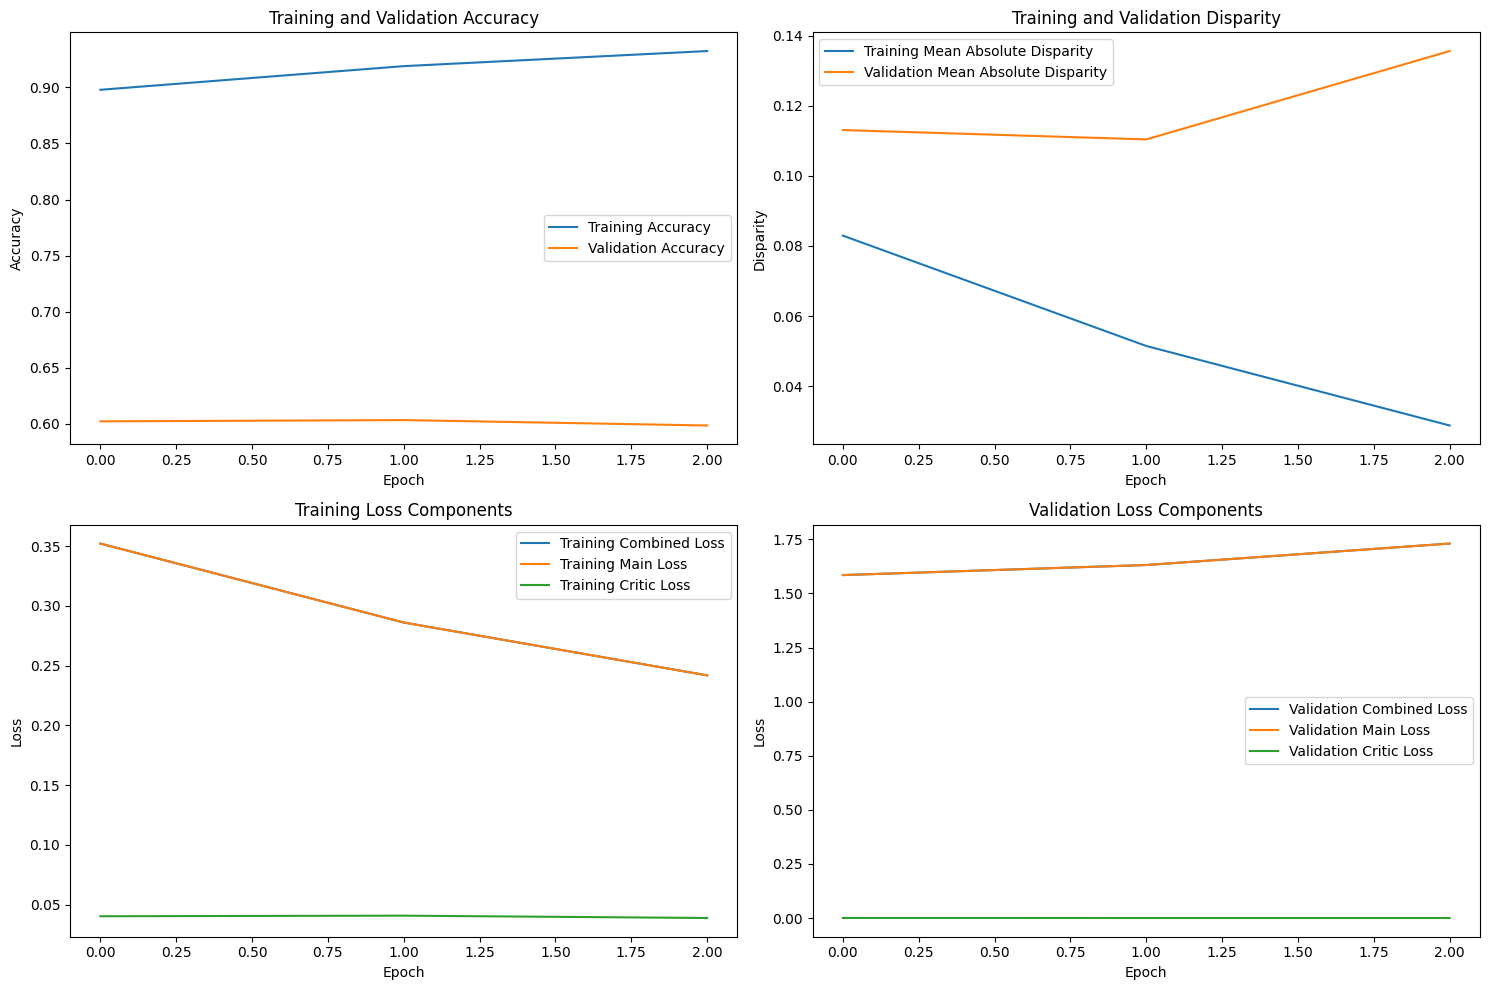

Epoch 4/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.29it/s]



Lambda 0 - Epoch 4 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.943229, VALIDATION Accuracy: 0.6049
TRAINING Disparity: 0.042069, VALIDATION Disparity: 0.1216
TRAINING Combined Loss: 0.202017, VALIDATION Combined Loss: 1.7849
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.06774742662599542
Class Celebration: Val Disparity = -0.009455445544554464
Class Parade: Val Disparity = 0.1297348484848483
Class Waiter_Or_Waitress: Val Disparity = -0.04467353951890041
Class Individual_Sports: Val Disparity = -0.10241104868913864
Class Surgeons: Val Disparity = -0.057649667405765104
Class Spa: Val Disparity = -0.04166666666666663
Class Law_Enforcement: Val Disparity = 0.008215962441314728
Class Business: Val Disparity = -0.0640902799957414
Class Dresses: Val Disparity = -0.6946107784431138
Class Water_Activities: Val Disparity = 0.0008516074089843784
Class Picnic: Val Disparity = -0.36601307189542487
Class Rescue: Val Dis

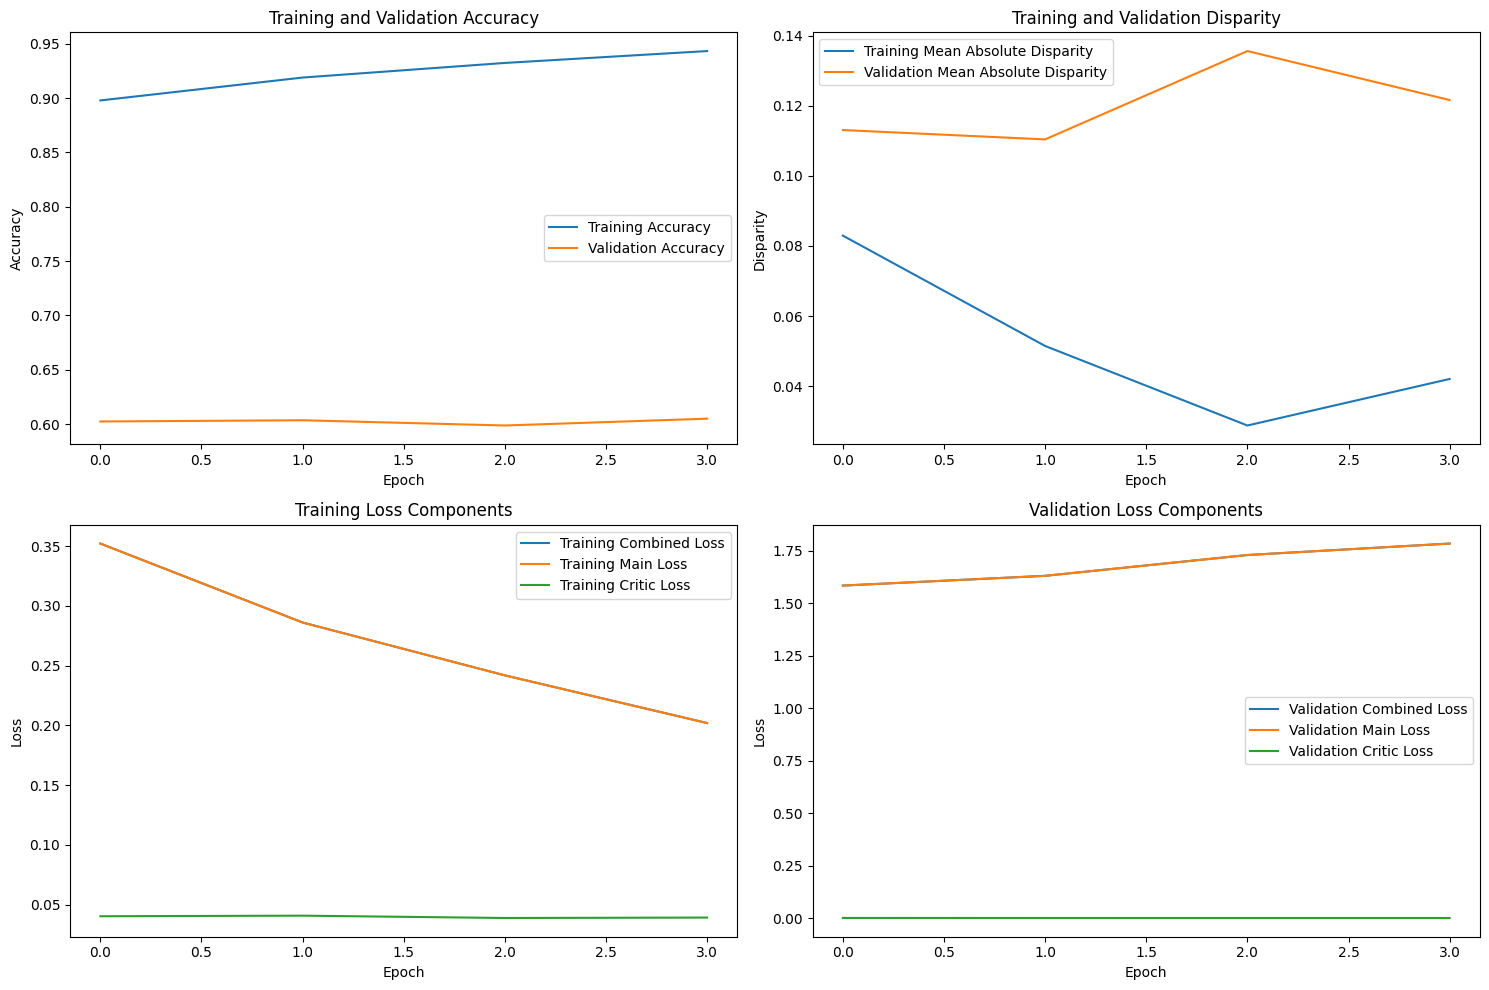

Epoch 5/200, Training:  46%|█████████████████████████████████████████                                                 | 74/162 [00:42<00:48,  1.82it/s]

In [ ]:
# Create dict to store best model states
all_best_model_states = {}
base_save_dir = "Test_Dir"

lambda_factor = 100

# Loop through the lambda_factor_list
for lambda_factor in lambda_factor_list:
    best_model_state = train_model(actor, actor_optimizer, actor_loss_fn, critic, critic_optimizer, critic_loss_fn,
                                   lambda_factor, epsilon, margin, patience, epochs, device, base_save_dir=base_save_dir)
    all_best_model_states[lambda_factor] = best_model_state

# Save the collective best model states to a file
collective_save_path = os.path.join(base_save_dir, 'all_best_model_states.pth')
torch.save(all_best_model_states, collective_save_path)


In [ ]:
# load models
collective_save_path = os.path.join(base_save_dir, 'all_best_model_states.pth')

# Load the saved model states
all_best_model_states = torch.load(collective_save_path)

# Example: Accessing the best_val_accuracy for a specific lambda value
lambda_value = 50
    if lambda_value in all_best_model_states:
        best_model_state = all_best_model_states[lambda_value]
        best_val_accuracy = best_model_state['best_val_accuracy']
        print(f"Best validation accuracy for lambda {lambda_value}: {best_val_accuracy}")
    else:
        print(f"No model state found for lambda {lambda_value}")

In [ ]:
# FOR REFERENCE - https://github.com/abacusai/intraprocessing_debiasing/blob/main/algorithms/adversarial.py
# 
# """
# Adversarial Intraprocessing Algorithm.
# """
# import logging

# import numpy as np
# import torch
# import torch.optim as optim

# from models import load_model, Critic
# from utils import get_best_thresh, get_test_objective, get_valid_objective, compute_bias

# logger = logging.getLogger("Debiasing")


# def adversarial_debiasing(model_state_dict, data, config, device):
#     logger.info('Training Adversarial model.')
#     actor = load_model(data.num_features, config.get('hyperparameters', {}))
#     actor.load_state_dict(model_state_dict)
#     actor.to(device)
#     hid = config['hyperparameters']['hid'] if 'hyperparameters' in config else 32
#     critic = Critic(hid * config['adversarial']['batch_size'], num_deep=config['adversarial']['num_deep'], hid=hid)
#     critic.to(device)
#     critic_optimizer = optim.Adam(critic.parameters())
#     critic_loss_fn = torch.nn.MSELoss()

#     actor_optimizer = optim.Adam(actor.parameters(), lr=config['adversarial']['lr'])
#     actor_loss_fn = torch.nn.BCELoss()

#     for epoch in range(config['adversarial']['epochs']):
#         for param in critic.parameters():
#             param.requires_grad = True
#         for param in actor.parameters():
#             param.requires_grad = False
#         actor.eval()
#         critic.train()
#         for step in range(config['adversarial']['critic_steps']):
#             critic_optimizer.zero_grad()
#             indices = torch.randint(0, data.X_valid.size(0), (config['adversarial']['batch_size'],))
#             cX_valid = data.X_valid_gpu[indices]
#             cy_valid = data.y_valid[indices]
#             cp_valid = data.p_valid[indices]
#             with torch.no_grad():
#                 scores = actor(cX_valid)[:, 0].reshape(-1).cpu().numpy()

#             bias = compute_bias(scores, cy_valid.numpy(), cp_valid, config['metric'])

#             res = critic(actor.trunc_forward(cX_valid))
#             loss = critic_loss_fn(torch.tensor([bias], device=device), res[0])
#             loss.backward()
#             train_loss = loss.item()
#             critic_optimizer.step()
#             if (epoch % 10 == 0) and (step % 100 == 0):
#                 logger.info(f'=======> Critic Epoch: {(epoch, step)} loss: {train_loss}')

#         for param in critic.parameters():
#             param.requires_grad = False
#         for param in actor.parameters():
#             param.requires_grad = True
#         actor.train()
#         critic.eval()
#         for step in range(config['adversarial']['actor_steps']):
#             actor_optimizer.zero_grad()
#             indices = torch.randint(0, data.X_valid.size(0), (config['adversarial']['batch_size'],))
#             cy_valid = data.y_valid_gpu[indices]
#             cX_valid = data.X_valid_gpu[indices]

#             pred_bias = critic(actor.trunc_forward(cX_valid)) # outputs of adversary model
#             bceloss = actor_loss_fn(actor(cX_valid)[:, 0], cy_valid)

#             # loss = lam*abs(pred_bias) + (1-lam)*loss   

#             # max(1, lambda * abs(outputs of adversary model) - epsilon (hypderparam) + margin + 1)
#             # epsilon = target bias (0.09?)
#             # margin = margin of error
#             objloss = max(1, config['adversarial']['lambda']*(abs(pred_bias[0][0])-config['objective']['epsilon']+config['adversarial']['margin'])+1) * bceloss
#             # ce-loss instead of BCE
#             # dont need to binarize
            
#             objloss.backward()
#             train_loss = objloss.item()
#             actor_optimizer.step()
#             if (epoch % 10 == 0) and (step % 100 == 0):
#                 logger.info(f'=======> Actor Epoch: {(epoch, step)} loss: {train_loss}')

#         if epoch % 10 == 0:
#             with torch.no_grad():
#                 scores = actor(data.X_valid_gpu)[:, 0].reshape(-1, 1).cpu().numpy()
#                 _, best_adv_obj = get_best_thresh(scores, np.linspace(0, 1, 1001), data, config, valid=False, margin=config['adversarial']['margin'])
#                 logger.info(f'Objective: {best_adv_obj}')

#     logger.info('Finding optimal threshold for Adversarial model.')
#     with torch.no_grad():
#         scores = actor(data.X_valid_gpu)[:, 0].reshape(-1, 1).cpu().numpy()

#     best_adv_thresh, _ = get_best_thresh(scores, np.linspace(0, 1, 1001), data, config, valid=False, margin=config['adversarial']['margin'])

#     logger.info('Evaluating Adversarial model on best threshold.')
#     with torch.no_grad():
#         labels = (actor(data.X_valid_gpu)[:, 0] > best_adv_thresh).reshape(-1, 1).cpu().numpy()
#     results_valid = get_valid_objective(labels, data, config)
#     logger.info(f'Results: {results_valid}')

#     with torch.no_grad():
#         labels = (actor(data.X_test_gpu)[:, 0] > best_adv_thresh).reshape(-1, 1).cpu().numpy()
#     results_test = get_test_objective(labels, data, config)

#     # return results_valid, results_test